<a href="https://colab.research.google.com/github/DABallentine/knowledge_discovery_charlotte/blob/main/Jupiter%20Notebooks/Association_Rule_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Association Rule Mining

This Notebook takes the merged service requests and creates association rules on the data

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
!pip install apyori
from apyori import apriori
import random
%matplotlib inline
plt.style.use('ggplot')

# Function to read data from URL
def read_data_from_URL(url):
    df=pd.read_csv(url)
    return df

In [2]:
#import the association rule packages
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

In [3]:
# Read in the merged, preprocessed data
serv_req_url='https://bitbucket.org/nthammad-uncc/knowledge_discovery_charlotte/raw/main/data/merged_requests.zip'
requests = read_data_from_URL(serv_req_url)
requests.head()

Unnamed: 0  OBJECTID             DEPARTMENT  REQUEST_NO  \
0           0         1   Solid Waste Services     6402056   
1           1         2  Housing and NBHD Serv     6402064   
2           2         3   Solid Waste Services     6402082   
3           3         4   Solid Waste Services     6402103   
4           4         6           Finance/City     6402112   

                REQUEST_CAT              REQUEST_TYPE        RECEIVED_DATE  \
0      NON_RECYCLABLE ITEMS      NON_RECYCLABLE ITEMS  2016-11-07 14:00:00   
1  UTILITY VERIFICATION LTR  UTILITY VERIFICATION LTR  2016-11-07 14:00:00   
2      NON_RECYCLABLE ITEMS      NON_RECYCLABLE ITEMS  2016-11-07 14:00:00   
3            MISSED SERVICE          MISSED RECYCLING  2016-11-07 14:00:00   
4                       CWP               CWP REQUEST  2016-11-07 14:00:00   

   RECEIVED_MONTH  RECEIVED_YEAR  SEASON  ...  \
0              11           2016       4  ...   
1              11           2016       4  ...   
2              11           2016       4  ...   
3              11           2016       4  ...   
4              11           2016       4  ...   

  PERCENT HOUSEHOLD INCOME_Higher Income Households  \
0                                          0.210336   
1                                          0.084375   
2                                          0.037530   
3                                          0.053345   
4                                          0.050732   

   PERCENT HOUSEHOLD INCOME_Retired Householders  \
0                                       0.157483   
1                                       0.129942   
2                                       0.113167   
3                                       0.128969   
4                                       0.097692   

   INCOME AND BENEFITS_Median households income (dollars)  \
0                                       79300.428571        
1                                       63391.250000        
2                                       41973.411765        
3                                       46401.066667        
4                                       42745.529412        

   INCOME AND BENEFITS_Mean households income (dollars)  \
0                                      111885.642857      
1                                       74852.450000      
2                                       51723.764706      
3                                       59119.666667      
4                                       53659.352941      

   INCOME AND BENEFITS_Per capita Income  \
0                           47529.928571   
1                           29914.900000   
2                           19338.294118   
3                           22976.800000   
4                           23808.882353   

   INCOME AND BENEFITS_Median earnings for workers (dollars)  \
0                                       43332.642857           
1                                       37226.300000           
2                                       23576.882353           
3                                       28399.600000           
4                                       29559.117647           

   PERCENT INSURED_Population with health insurance  \
0                                          0.917971   
1                                          0.869184   
2                                          0.814082   
3                                          0.834642   
4                                          0.825033   

   PERCENT INSURED_Population without health insurance  \
0                                           0.082029     
1                                           0.130816     
2                                           0.185918     
3                                           0.165358     
4                                           0.174967     

  PERCENTAGE BELOW POVERTY LEVEL_All  HISTORIC_REDLINING  
0                           7.135714                 NaN  
1                           8.050000                

In [4]:
#list all column names
requests.columns.values

array(['Unnamed: 0', 'OBJECTID', 'DEPARTMENT', 'REQUEST_NO',
       'REQUEST_CAT', 'REQUEST_TYPE', 'RECEIVED_DATE', 'RECEIVED_MONTH',
       'RECEIVED_YEAR', 'SEASON', 'INTERNAL_FIELD_OBSERVATION',
       'NEIGHBORHOOD_PROFILE_AREA', 'BLOCK_NO', 'ZIP_CODE', 'X_COORD',
       'Y_COORD', 'LATITUDE', 'LONGITUDE', 'RECEIVED_DAY', 'TOTAL_CALLS',
       'ADDRESS_ID', 'CRIME_SCORE', 'EMPLOYED_All',
       'PERCENT EMPLOYED_In labor force',
       'PERCENT EMPLOYED_Not in labor force',
       'PERCENT EMPLOYED_Female Only', 'COMMUTING TO WORK_All',
       'PERCENT COMMUTING TO WORK_By Car',
       'PERCENT COMMUTING TO WORK_Public transportation',
       'PERCENT COMMUTING TO WORK_Walk',
       'PERCENT COMMUTING TO WORK_Other',
       'PERCENT COMMUTING TO WORK_Worked at home',
       'INCOME AND BENEFITS_Total households',
       'PERCENT HOUSEHOLD INCOME_Lower Income Households',
       'PERCENT HOUSEHOLD INCOME_Mid Income Households',
       'PERCENT HOUSEHOLD INCOME_Higher Income Househol

In [5]:
#calculate the day of the week to make the request count per neighborhood profile area lesser
requests['RECEIVED_DAY_OF_WEEK'] = pd.to_datetime(requests['RECEIVED_DATE']).dt.day_name()
requests['RECEIVED_MONTH']=requests['RECEIVED_MONTH'].apply(lambda x:str(x))

In [6]:
#function to calculate if the income bracket is predominantly low, mid or high
def calculate_income_bracket(low,mid,high):
    if low>mid and low>high:
        return 'Low'
    elif mid>high:
        return 'Mid'
    else:
        return 'High'

In [7]:
requests['PREDOMINANT_INCOME_BRACKET']=requests[['PERCENT HOUSEHOLD INCOME_Lower Income Households','PERCENT HOUSEHOLD INCOME_Mid Income Households','PERCENT HOUSEHOLD INCOME_Higher Income Households']].apply(lambda x: calculate_income_bracket(*x),axis=1)


In [8]:
requests['PREDOMINANT_INCOME_BRACKET'].value_counts()

Mid     1491811
Low       29346
High       2904
Name: PREDOMINANT_INCOME_BRACKET, dtype: int64

In [9]:
requests['CRIME_SCORE']=requests['CRIME_SCORE'].apply(lambda x: round(x,3))
requests['NEIGHBORHOOD_PROFILE_AREA']=requests['NEIGHBORHOOD_PROFILE_AREA'].apply(lambda x: str(int(x)))

In [10]:
max_crime_score=requests['CRIME_SCORE'].max()
requests['CRIME_INDEX']=requests['CRIME_SCORE'].apply(lambda x: 'Low' if (x/max_crime_score)<=0.33 else ('Mid' if (x/max_crime_score)<=0.66 else 'High'))

In [11]:
requests.head()

Unnamed: 0  OBJECTID             DEPARTMENT  REQUEST_NO  \
0           0         1   Solid Waste Services     6402056   
1           1         2  Housing and NBHD Serv     6402064   
2           2         3   Solid Waste Services     6402082   
3           3         4   Solid Waste Services     6402103   
4           4         6           Finance/City     6402112   

                REQUEST_CAT              REQUEST_TYPE        RECEIVED_DATE  \
0      NON_RECYCLABLE ITEMS      NON_RECYCLABLE ITEMS  2016-11-07 14:00:00   
1  UTILITY VERIFICATION LTR  UTILITY VERIFICATION LTR  2016-11-07 14:00:00   
2      NON_RECYCLABLE ITEMS      NON_RECYCLABLE ITEMS  2016-11-07 14:00:00   
3            MISSED SERVICE          MISSED RECYCLING  2016-11-07 14:00:00   
4                       CWP               CWP REQUEST  2016-11-07 14:00:00   

  RECEIVED_MONTH  RECEIVED_YEAR  SEASON  ...  \
0             11           2016       4  ...   
1             11           2016       4  ...   
2             11           2016       4  ...   
3             11           2016       4  ...   
4             11           2016       4  ...   

  INCOME AND BENEFITS_Mean households income (dollars)  \
0                                      111885.642857     
1                                       74852.450000     
2                                       51723.764706     
3                                       59119.666667     
4                                       53659.352941     

  INCOME AND BENEFITS_Per capita Income  \
0                          47529.928571   
1                          29914.900000   
2                          19338.294118   
3                          22976.800000   
4                          23808.882353   

   INCOME AND BENEFITS_Median earnings for workers (dollars)  \
0                                       43332.642857           
1                                       37226.300000           
2                                       23576.882353           
3                                       28399.600000           
4                                       29559.117647           

   PERCENT INSURED_Population with health insurance  \
0                                          0.917971   
1                                          0.869184   
2                                          0.814082   
3                                          0.834642   
4                                          0.825033   

   PERCENT INSURED_Population without health insurance  \
0                                           0.082029     
1                                           0.130816     
2                                           0.185918     
3                                           0.165358     
4                                           0.174967     

   PERCENTAGE BELOW POVERTY LEVEL_All  HISTORIC_REDLINING  \
0                            7.135714                 NaN   
1                            8.050000                 NaN   
2                           25.811765                 NaN   
3                           16.960000                 NaN   
4                           20.682353                   Y   

   RECEIVED_DAY_OF_WEEK PREDOMINANT_INCOME_BRACKET  CRIME_INDEX  
0                Monday                        Mid          Low  
1                Monday                        Mid          Low  
2                Monday                        Mid          Low  
3                Monday                        Mid          Low  
4                Monday                        Mid          Low  

[5 rows x 48 columns]

## Association rules between Request Categories and Neighborhood Profile Areas

In [12]:
requests['REQUEST_CAT'].value_counts()

NON_RECYCLABLE ITEMS         820199
RECYCLABLE ITEMS             196945
CART                         107771
HNS HEALTH AND SANITATION     77723
TRANSPORTATION                52467
MISSED SERVICE                43400
GARBAGE                       30604
311 DOCUMENT                  22379
RECYCLING                     22200
VIOLATIONS                    15821
YARD WASTE                    15796
TIRES                         13440
WEATHER AND ENVIRONMENTAL     11641
ZONING                        11410
DEAD ANIMAL COLLECTION        10701
ZONING/COMPLAINT/ INSPECT      9994
COMPLAINT                      8486
HNS HOUSING                    8161
BULKY ITEM                     8045
ZON GENERAL INFO  INQUIRY      7894
CUSTOMER FEEDBACK              6835
BLOCKAGE                       4462
CLEANLINESS                    3447
CWP                            2645
DISABILITY ACT                 2525
ADMINISTRATIVE ACTIONS         2326
ESCALATION REQUEST             1791
UTILITY VERIFICATION LTR    

In [13]:
#create a column to combine month, year and neighborhood profile area:
requests['MERGE_INDEX']=requests['RECEIVED_MONTH'].astype('str')+'_'+requests['RECEIVED_YEAR'].astype('str')+'_'+requests['NEIGHBORHOOD_PROFILE_AREA'].astype('str')
requests['REQ_COUNT']=1

In [14]:
requests.head()

Unnamed: 0  OBJECTID             DEPARTMENT  REQUEST_NO  \
0           0         1   Solid Waste Services     6402056   
1           1         2  Housing and NBHD Serv     6402064   
2           2         3   Solid Waste Services     6402082   
3           3         4   Solid Waste Services     6402103   
4           4         6           Finance/City     6402112   

                REQUEST_CAT              REQUEST_TYPE        RECEIVED_DATE  \
0      NON_RECYCLABLE ITEMS      NON_RECYCLABLE ITEMS  2016-11-07 14:00:00   
1  UTILITY VERIFICATION LTR  UTILITY VERIFICATION LTR  2016-11-07 14:00:00   
2      NON_RECYCLABLE ITEMS      NON_RECYCLABLE ITEMS  2016-11-07 14:00:00   
3            MISSED SERVICE          MISSED RECYCLING  2016-11-07 14:00:00   
4                       CWP               CWP REQUEST  2016-11-07 14:00:00   

  RECEIVED_MONTH  RECEIVED_YEAR  SEASON  ...  \
0             11           2016       4  ...   
1             11           2016       4  ...   
2             11           2016       4  ...   
3             11           2016       4  ...   
4             11           2016       4  ...   

  INCOME AND BENEFITS_Median earnings for workers (dollars)  \
0                                       43332.642857          
1                                       37226.300000          
2                                       23576.882353          
3                                       28399.600000          
4                                       29559.117647          

  PERCENT INSURED_Population with health insurance  \
0                                         0.917971   
1                                         0.869184   
2                                         0.814082   
3                                         0.834642   
4                                         0.825033   

   PERCENT INSURED_Population without health insurance  \
0                                           0.082029     
1                                           0.130816     
2                                           0.185918     
3                                           0.165358     
4                                           0.174967     

   PERCENTAGE BELOW POVERTY LEVEL_All  HISTORIC_REDLINING  \
0                            7.135714                 NaN   
1                            8.050000                 NaN   
2                           25.811765                 NaN   
3                           16.960000                 NaN   
4                           20.682353                   Y   

   RECEIVED_DAY_OF_WEEK  PREDOMINANT_INCOME_BRACKET  CRIME_INDEX  MERGE_INDEX  \
0                Monday                         Mid          Low  11_2016_215   
1                Monday                         Mid          Low  11_2016_265   
2                Monday                         Mid          Low  11_2016_103   
3                Monday                         Mid          Low  11_2016_158   
4                Monday                         Mid          Low   11_2016_88   

   REQ_COUNT  
0          1  
1          1  
2          1  
3          1  
4          1  

[5 rows x 50 columns]

In [15]:
#create a matrix of merge index and category with the values as sum of requests(number of requests of 
# a particular category raised per month of a year for a particular neighborhood profile area) 
request_basket = (requests
          .groupby(['MERGE_INDEX','REQUEST_CAT'])['REQ_COUNT']
          .sum().unstack().reset_index().fillna(0)
          .set_index('MERGE_INDEX'))
request_basket.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
MERGE_INDEX                                                             
10_2016_10            3.0                     2.0                 0.0   
10_2016_100           2.0                     0.0                 0.0   
10_2016_101           0.0                     0.0                 0.0   
10_2016_102           0.0                     0.0                 0.0   
10_2016_103           1.0                     0.0                 0.0   
10_2016_105           0.0                     1.0                 0.0   
10_2016_106           0.0                     0.0                 0.0   
10_2016_107           1.0                     0.0                 0.0   
10_2016_108           0.0                     0.0                 0.0   
10_2016_109           0.0                     0.0                 0.0   
10_2016_11            2.0                     0.0                 0.0   
10_2016_110           0.0                     0.0                 0.0   
10_2016_111           0.0                     0.0                 0.0   
10_2016_112           0.0                     0.0                 0.0   
10_2016_113           3.0                     0.0                 0.0   
10_2016_114           0.0                     1.0                 0.0   
10_2016_115           0.0                     0.0                 0.0   
10_2016_116           4.0                     1.0                 0.0   
10_2016_117           3.0                     3.0                 0.0   
10_2016_118           0.0                     0.0                 0.0   

REQUEST_CAT  ANIMAL FOUND REPORT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  \
MERGE_INDEX                                                                    
10_2016_10                   0.0       0.0                   0.0         2.0   
10_2016_100                  0.0       0.0                   0.0         0.0   
10_2016_101                  0.0       0.0                   0.0         0.0   
10_2016_102                  0.0       0.0                   0.0         0.0   
10_2016_103                  0.0       0.0                   0.0         0.0   
10_2016_105                  0.0       0.0                   0.0         0.0   
10_2016_106                  0.0       0.0                   0.0         0.0   
10_2016_107                  0.0       0.0                   0.0         0.0   
10_2016_108                  0.0       0.0                   0.0         0.0   
10_2016_109                  0.0       0.0                   0.0         0.0   
10_2016_11                   0.0       1.0                   0.0         0.0   
10_2016_110                  0.0       0.0                   0.0         0.0   
10_2016_111                  0.0       0.0                   0.0         0.0   
10_2016_112                  0.0       0.0                   0.0         0.0   
10_2016_113                  0.0       0.0                   0.0         1.0   
10_2016_114                  0.0       0.0                   0.0         0.0   
10_2016_115                  0.0       1.0                   0.0         0.0   
10_2016_116                  0.0       1.0                   0.0         1.0   
10_2016_117                  0.0       0.0                   0.0         1.0   
10_2016_118                  0.0       0.0                   0.0         0.0   

REQUEST_CAT  CART  CLEANLINESS  COMPLAINT  ...  SW ONLY-DOOR HANGER LEFT  \
MERGE_INDEX                                ...                             
10_2016_10   18.0          0.0        0.0  ...                       0.0   
10_2016_100   4.0          0.0        1.0  ...                       0.0   
10_2016_101   1.0          1.0        0.0  ...                       0.0   
10_2016_102   2.0          0.0        0.0  ...                       0.0   
10_2016_103   2.0          0.0        0.0  ...                       0.0   
10_2016_105   0.0          0.0        0.0  ...                       0.0   
10_2016_106   0.0       

In [16]:
#check the min and max using describe
request_basket.describe()

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
count        26271.000000            26271.000000        26271.000000   
mean             0.851852                0.088539            0.003883   
std              1.191478                0.366885            0.071847   
min              0.000000                0.000000            0.000000   
25%              0.000000                0.000000            0.000000   
50%              0.000000                0.000000            0.000000   
75%              1.000000                0.000000            0.000000   
max             14.000000                8.000000            4.000000   

REQUEST_CAT  ANIMAL FOUND REPORT      BLOCKAGE  BOARDED UP STRUCTURE  \
count               26271.000000  26271.000000          26271.000000   
mean                    0.045487      0.169845              0.008565   
std                     0.218714      0.464095              0.099690   
min                     0.000000      0.000000              0.000000   
25%                     0.000000      0.000000              0.000000   
50%                     0.000000      0.000000              0.000000   
75%                     0.000000      0.000000              0.000000   
max                     4.000000      9.000000              3.000000   

REQUEST_CAT    BULKY ITEM          CART   CLEANLINESS     COMPLAINT  ...  \
count        26271.000000  26271.000000  26271.000000  26271.000000  ...   
mean             0.306231      4.102280      0.131209      0.323018  ...   
std              0.670135      6.281683      0.409941      0.629465  ...   
min              0.000000      0.000000      0.000000      0.000000  ...   
25%              0.000000      0.000000      0.000000      0.000000  ...   
50%              0.000000      2.000000      0.000000      0.000000  ...   
75%              0.000000      5.000000      0.000000      1.000000  ...   
max              9.000000    114.000000      6.000000      7.000000  ...   

REQUEST_CAT  SW ONLY-DOOR HANGER LEFT         TIRES  TRANSPORTATION  \
count                    26271.000000  26271.000000    26271.000000   
mean                         0.014084      0.511591        1.997145   
std                          0.205444      0.978805        2.664610   
min                          0.000000      0.000000        0.000000   
25%                          0.000000      0.000000        0.000000   
50%                          0.000000      0.000000        1.000000   
75%                          0.000000      1.000000        3.000000   
max                         15.000000     15.000000       49.000000   

REQUEST_CAT  UTILITY VERIFICATION LTR    VIOLATIONS  \
count                    26271.000000  26271.000000   
mean                         0.054851      0.602223   
std                          0.269497      1.459714   
min                          0.000000      0.000000   
25%                          0.000000      0.000000   
50%                          0.000000      0.000000   
75%                          0.000000      1.000000   
max                          6.000000     29.000000   

REQUEST_CAT  WEATHER AND ENVIRONMENTAL    YARD WASTE  \
count                     26271.000000  26271.000000   
mean                          0.443112      0.601271   
std                           0.939404      1.241221   
min                           0.000000      0.000000   
25%                           0.000000      0.000000   
50%                           0.000000      0.000000   
75%                           1.000000      1.000000   
max                          30.000000     30.000000   

REQUEST_CAT  ZON GENERAL INFO  INQUIRY        ZONING  \
count                     26271.000000  26271.000000   
mean                          0.300483      0.434319   
std                           0.649909      0.842676   
min                           0.000000      0.000000   
25%                           0.000000      0.000000   
50%                           0

In [17]:
request_basket.columns

Index(['311 DOCUMENT', 'ADMINISTRATIVE ACTIONS', 'ADOPT-A PICKUP SWS',
       'ANIMAL FOUND REPORT', 'BLOCKAGE', 'BOARDED UP STRUCTURE', 'BULKY ITEM',
       'CART', 'CLEANLINESS', 'COMPLAINT', 'CONTENT IMPROVEMENT PROG',
       'CUSTOMER FEEDBACK', 'CWP', 'DEAD ANIMAL COLLECTION', 'DISABILITY ACT',
       'DISABLED SERVICE', 'ESCALATION REQUEST', 'FIELD OBSERVED PROBLEM',
       'GARBAGE', 'HNS HEALTH AND SANITATION', 'HNS HOUSING', 'MISSED SERVICE',
       'NON_RECYCLABLE ITEMS', 'PARK & REC SVC REQUEST', 'RECYCLABLE ITEMS',
       'RECYCLING', 'REQUEST FOR SPEAKER', 'STW CNTY WATER QUALITY',
       'STW OTHER', 'SW ONLY-DOOR HANGER LEFT', 'TIRES', 'TRANSPORTATION',
       'UTILITY VERIFICATION LTR', 'VIOLATIONS', 'WEATHER AND ENVIRONMENTAL',
       'YARD WASTE', 'ZON GENERAL INFO  INQUIRY', 'ZONING',
       'ZONING/COMPLAINT/ INSPECT'],
      dtype='object', name='REQUEST_CAT')

In [18]:
#function to encode the value of a cell as 1 if it is >=1 and as 0 if it is <=0
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

    
#update the values in the request_basket_sets
request_basket_sets = request_basket.applymap(encode_units)

In [19]:
request_basket_sets.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
MERGE_INDEX                                                             
10_2016_10              1                       1                   0   
10_2016_100             1                       0                   0   
10_2016_101             0                       0                   0   
10_2016_102             0                       0                   0   
10_2016_103             1                       0                   0   
10_2016_105             0                       1                   0   
10_2016_106             0                       0                   0   
10_2016_107             1                       0                   0   
10_2016_108             0                       0                   0   
10_2016_109             0                       0                   0   
10_2016_11              1                       0                   0   
10_2016_110             0                       0                   0   
10_2016_111             0                       0                   0   
10_2016_112             0                       0                   0   
10_2016_113             1                       0                   0   
10_2016_114             0                       1                   0   
10_2016_115             0                       0                   0   
10_2016_116             1                       1                   0   
10_2016_117             1                       1                   0   
10_2016_118             0                       0                   0   

REQUEST_CAT  ANIMAL FOUND REPORT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  \
MERGE_INDEX                                                                    
10_2016_10                     0         0                     0           1   
10_2016_100                    0         0                     0           0   
10_2016_101                    0         0                     0           0   
10_2016_102                    0         0                     0           0   
10_2016_103                    0         0                     0           0   
10_2016_105                    0         0                     0           0   
10_2016_106                    0         0                     0           0   
10_2016_107                    0         0                     0           0   
10_2016_108                    0         0                     0           0   
10_2016_109                    0         0                     0           0   
10_2016_11                     0         1                     0           0   
10_2016_110                    0         0                     0           0   
10_2016_111                    0         0                     0           0   
10_2016_112                    0         0                     0           0   
10_2016_113                    0         0                     0           1   
10_2016_114                    0         0                     0           0   
10_2016_115                    0         1                     0           0   
10_2016_116                    0         1                     0           1   
10_2016_117                    0         0                     0           1   
10_2016_118                    0         0                     0           0   

REQUEST_CAT  CART  CLEANLINESS  COMPLAINT  ...  SW ONLY-DOOR HANGER LEFT  \
MERGE_INDEX                                ...                             
10_2016_10      1            0          0  ...                         0   
10_2016_100     1            0          1  ...                         0   
10_2016_101     1            1          0  ...                         0   
10_2016_102     1            0          0  ...                         0   
10_2016_103     1            0          0  ...                         0   
10_2016_105     0            0          0  ...                         0   
10_2016_106     0       

### Association Rules concepts:
"Support" is the relative frequency that the rules show up. In many instances, you may want to look for high support in order to make sure it is a useful relationship. However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.

"Confidence" is a measure of the reliability of the rule. A confidence of .5 in in an association rule X --> Y would mean that in 50% of the cases where X occurs, Y also occurs. Confidence that can be used as a threshold differs from industry to industry and case to case. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.

"Lift" is the ratio of the observed support to that expected if the two rules were independent. The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.

<img src="https://wiki.smu.edu.sg/1718t3isss608/img_auth.php/thumb/b/b3/Lift_Confidence_Support.png/600px-Lift_Confidence_Support.png" alt="support_confidence_lift" />

In [20]:
#get the frequent lists with min support of 0.4
frequent_itemsets = fpgrowth(request_basket_sets, min_support=0.4, use_colnames=True)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.max_colwidth', None):
    display(frequent_itemsets.sort_values(['support'],ascending=False))


support  \
0   0.871988   
1   0.811427   
9   0.811046   
2   0.714019   
10  0.712801   
11  0.692398   
12  0.692284   
3   0.650413   
13  0.642990   
4   0.625366   
20  0.621217   
14  0.619695   
16  0.619619   
24  0.601995   
21  0.601995   
15  0.565376   
17  0.565110   
18  0.554794   
19  0.554794   
22  0.548932   
25  0.548704   
26  0.539759   
27  0.539759   
5   0.521335   
35  0.520117   
23  0.503293   
28  0.502227   
6   0.500818   
46  0.500095   
36  0.499296   
39  0.499258   
31  0.492596   
29  0.492596   
47  0.488143   
51  0.488105   
7   0.487458   
30  0.457691   
32  0.457539   
48  0.456587   
52  0.456359   
37  0.456206   
40  0.455826   
33  0.452400   
34  0.452400   
54  0.449469   
53  0.449469   
41  0.446348   
42  0.446348   
59  0.418865   
38  0.411861   
43  0.411556   
49  0.407522   
55  0.407293   
60  0.406342   
61  0.406227   
8   0.404134   
62  0.403867   
44  0.401926   
45  0.401888   
56  0.401203   
57  0.401165   
50  0.400137   
58  0.400023   

                                                                                     itemsets  
0                                                                      (NON_RECYCLABLE ITEMS)  
1                                                                          (RECYCLABLE ITEMS)  
9                                                    (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS)  
2                                                                                      (CART)  
10                                                               (NON_RECYCLABLE ITEMS, CART)  
11                                                                   (CART, RECYCLABLE ITEMS)  
12                                             (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS)  
3                                                                            (TRANSPORTATION)  
13                                                     (NON_RECYCLABLE ITEMS, TRANSPORTATION)  
4                                                                 (HNS HEALTH AND SANITATION)  
20                                          (NON_RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)  
14                                                         (RECYCLABLE ITEMS, TRANSPORTATION)  
16                                   (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, TRANSPORTATION)  
24                        (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)  
21                                              (RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)  
15                                                                     (CART, TRANSPORTATION)  
17                                               (NON_RECYCLABLE ITEMS, CART, TRANSPORTATION)  
18                                                   (CART, RECYCLABLE ITEMS, TRANSPORTATION)  
19                             (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS, TRANSPORTATION)  
22                                                          (CART, HNS HEALTH AND SANITATION)  
25                                    (NON_RECYCLABLE ITEMS, CART, HNS HEALTH AND SANITATION)  
26                                        (CART, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)  
27                  (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)  
5                                                                            (MISSED SERVICE)  
35                                                     (MISSED SERVICE, NON_RECYCLABLE ITEMS)  
23                                                (HNS HEALTH AND SANITATION, TRANSPORTATION)  
28                          (NON_RECYCLABLE ITEMS, HNS HEALTH AND SANITATION, TRANSPORTATION)  
6                                                                                   (GARBAGE)  
46                                                            (NON_RECYCLABLE ITEMS, GARBAGE)  
36                                                         (MISSED SERVICE, RECYCLABLE ITEMS)  
39  

### Inference:

We can see that the support of NON_RECYCLABLE ITEMS and RECYCLABLE ITEMS is the highest in the frequest item sets which aligns with our data because these two are the highest reported type of 311 service requests.

The next highest are CART, TRANSPORTATION, HNS HEALTH AND SANITATION, MISSED SERVICE, GARBAGE and RECYCLING. All these are likely to occur in the same neighborhood profile area along with NON_RECYCLABLE ITEMS and RECYCLABLE ITEMS within a time-span of a month. 

We also see a few instances of 311 DOCUMENT which is likely to occur with NON_RECYCLABLE ITEMS and RECYCLABLE ITEMS

In [21]:
#function for creating association rules
def create_assoc_rules(metric, min_support, min_threshold, basket_sets):
    frequent_reqsets = apriori(basket_sets, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_reqsets, metric=metric, min_threshold=min_threshold)
    return rules

In [22]:
#creating the frequest request sets. We use a minimum support of 0.1 to create 
# more number of frequent lists than seen above
rules=create_assoc_rules("lift",0.1,1,request_basket_sets)
rules.head(30)

antecedents                  consequents  \
0                  (BULKY ITEM)               (311 DOCUMENT)   
1                (311 DOCUMENT)                 (BULKY ITEM)   
2                        (CART)               (311 DOCUMENT)   
3                (311 DOCUMENT)                       (CART)   
4                   (COMPLAINT)               (311 DOCUMENT)   
5                (311 DOCUMENT)                  (COMPLAINT)   
6           (CUSTOMER FEEDBACK)               (311 DOCUMENT)   
7                (311 DOCUMENT)          (CUSTOMER FEEDBACK)   
8      (DEAD ANIMAL COLLECTION)               (311 DOCUMENT)   
9                (311 DOCUMENT)     (DEAD ANIMAL COLLECTION)   
10                    (GARBAGE)               (311 DOCUMENT)   
11               (311 DOCUMENT)                    (GARBAGE)   
12  (HNS HEALTH AND SANITATION)               (311 DOCUMENT)   
13               (311 DOCUMENT)  (HNS HEALTH AND SANITATION)   
14                (HNS HOUSING)               (311 DOCUMENT)   
15               (311 DOCUMENT)                (HNS HOUSING)   
16             (MISSED SERVICE)               (311 DOCUMENT)   
17               (311 DOCUMENT)             (MISSED SERVICE)   
18           (RECYCLABLE ITEMS)               (311 DOCUMENT)   
19               (311 DOCUMENT)           (RECYCLABLE ITEMS)   
20                  (RECYCLING)               (311 DOCUMENT)   
21               (311 DOCUMENT)                  (RECYCLING)   
22                      (TIRES)               (311 DOCUMENT)   
23               (311 DOCUMENT)                      (TIRES)   
24             (TRANSPORTATION)               (311 DOCUMENT)   
25               (311 DOCUMENT)             (TRANSPORTATION)   
26                 (VIOLATIONS)               (311 DOCUMENT)   
27               (311 DOCUMENT)                 (VIOLATIONS)   
28  (WEATHER AND ENVIRONMENTAL)               (311 DOCUMENT)   
29               (311 DOCUMENT)  (WEATHER AND ENVIRONMENTAL)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.222717            0.487458  0.128583    0.577337  1.184384   
1             0.487458            0.222717  0.128583    0.263783  1.184384   
2             0.714019            0.487458  0.372692    0.521964  1.070788   
3             0.487458            0.714019  0.372692    0.764563  1.070788   
4             0.254235            0.487458  0.146169    0.574936  1.179459   
5             0.487458            0.254235  0.146169    0.299859  1.179459   
6             0.207339            0.487458  0.114575    0.552598  1.133632   
7             0.487458            0.207339  0.114575    0.235046  1.133632   
8             0.267557            0.487458  0.152221    0.568929  1.167135   
9             0.487458            0.267557  0.152221    0.312275  1.167135   
10            0.500818            0.487458  0.275589    0.550277  1.128872   
11            0.487458            0.500818  0.275589    0.565360  1.128872   
12            0.625366            0.487458  0.329831    0.527421  1.081983   
13            0.487458            0.625366  0.329831    0.676636  1.081983   
14            0.191276            0.487458  0.101861    0.532537  1.092479   
15            0.487458            0.191276  0.101861    0.208965  1.092479   
16            0.521335            0.487458  0.273115    0.523876  1.074710   
17            0.487458            0.521335  0.273115    0.560284  1.074710   
18            0.811427            0.487458  0.406342    0.500774  1.027318   
19            0.487458            0.811427  0.406342    0.833594  1.027318   
20            0.404134            0.487458  0.222907    0.551568  1.131520   
21            0.487458            0.404134  0.222907    0.457286  1.131520   
22            0.308934            0.487458  0.182863    0.591917  1.214295   
23            0.487458            0.308934  0.182863    0.375137  1.214295   
24            0.650413            0.487458  0.342393    0.526424  1.079937   
25     

In [23]:
rules.tail(30)

antecedents  \
116970  (RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
116971             (MISSED SERVICE, RECYCLABLE ITEMS)   
116972                  (RECYCLING, RECYCLABLE ITEMS)   
116973             (RECYCLABLE ITEMS, TRANSPORTATION)   
116974                       (CART, RECYCLABLE ITEMS)   
116975               (RECYCLABLE ITEMS, 311 DOCUMENT)   
116976    (MISSED SERVICE, HNS HEALTH AND SANITATION)   
116977         (RECYCLING, HNS HEALTH AND SANITATION)   
116978    (HNS HEALTH AND SANITATION, TRANSPORTATION)   
116979              (CART, HNS HEALTH AND SANITATION)   
116980      (HNS HEALTH AND SANITATION, 311 DOCUMENT)   
116981                    (MISSED SERVICE, RECYCLING)   
116982               (MISSED SERVICE, TRANSPORTATION)   
116983                         (MISSED SERVICE, CART)   
116984                 (MISSED SERVICE, 311 DOCUMENT)   
116985                    (RECYCLING, TRANSPORTATION)   
116986                              (RECYCLING, CART)   
116987                      (RECYCLING, 311 DOCUMENT)   
116988                         (CART, TRANSPORTATION)   
116989                 (311 DOCUMENT, TRANSPORTATION)   
116990                           (CART, 311 DOCUMENT)   
116991                         (NON_RECYCLABLE ITEMS)   
116992                                      (GARBAGE)   
116993                             (RECYCLABLE ITEMS)   
116994                    (HNS HEALTH AND SANITATION)   
116995                               (MISSED SERVICE)   
116996                                    (RECYCLING)   
116997                               (TRANSPORTATION)   
116998                                         (CART)   
116999                                 (311 DOCUMENT)   

                                              consequents  antecedent support  \
116970  (NON_RECYCLABLE ITEMS, GARBAGE, 311 DOCUMENT, ...            0.601995   
116971  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.499296   
116972  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.394503   
116973  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.619695   
116974  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.692398   
116975  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.406342   
116976  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.397587   
116977  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.319135   
116978  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.503293   
116979  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.548932   
116980  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.329831   
116981  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.300065   
116982  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.411861   
116983  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.456206   
116984  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.273115   
116985  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.334818   
116986  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.371741   
116987  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.222907   
116988  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.565376   
116989  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.342393   
116990  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.372692   
116991  (GARBAGE, RECYCLABLE ITEMS, HNS HEALTH AND SAN...            0.871988   
116992  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, HNS H...            0.500818   
116993  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.811427   
116994  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.625366   
116995  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.521335   
116996  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.404134   
116997

In [24]:
rules.describe()

antecedent support  consequent support        support     confidence  \
count       117000.000000       117000.000000  117000.000000  117000.000000   
mean             0.337491            0.337491       0.134623       0.508276   
std              0.188173            0.188173       0.043766       0.247092   
min              0.100148            0.100148       0.100148       0.114851   
25%              0.187736            0.187736       0.107761       0.301984   
50%              0.280347            0.280347       0.119790       0.461246   
75%              0.455826            0.455826       0.144304       0.697055   
max              0.871988            0.871988       0.811046       1.000000   

                lift       leverage    conviction  
count  117000.000000  117000.000000  1.170000e+05  
mean        1.543043       0.044619           inf  
std         0.189798       0.012621           NaN  
min         1.027318       0.007630  1.010300e+00  
25%         1.403026       0.037624  1.155712e+00  
50%         1.549216       0.044262  1.330334e+00  
75%         1.675661       0.051133  1.845136e+00  
max         2.121184       0.113898           inf

In [25]:
#function to plot the support, confidence and lift on a graph
def plot_assoc_rules(support,confidence,lift):
    for i in range (len(support)):
        support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
        confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.rcParams["figure.figsize"] = (30,10)

    ax1.scatter(support, confidence,   alpha=0.8, marker="*")
    ax2.scatter(lift, confidence,   alpha=0.8, marker="s",c='green')
    ax1.set(xlabel='support', ylabel='confidence')
    ax2.set(xlabel='lift')
    plt.show()

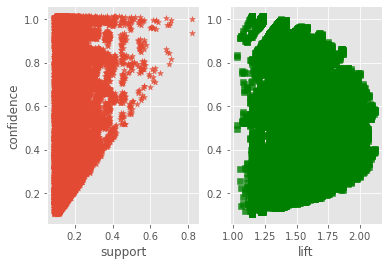

In [26]:
#plot association rules
plot_assoc_rules(rules[['support']].values,rules[['confidence']].values,rules[['lift']].values)

### Inference:
We see that the highest lift is 2.12 and we also have some perfect confidence scores of 1.

To select the most frequent association rules, we choose a high lift (>2) and a high confidence too (>0.65 which is close to the 75% mark)

In [27]:
#fetch the most reliable association rules
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.max_colwidth', None):
    display(rules[ (rules['lift'] >= 2) &
        (rules['confidence'] >= 0.65)].sort_values(['lift'],ascending=False) )

antecedents  \
98869                                           (RECYCLING, YARD WASTE, HNS HEALTH AND SANITATION)   
113635                                          (RECYCLING, YARD WASTE, HNS HEALTH AND SANITATION)   
113544                    (NON_RECYCLABLE ITEMS, YARD WASTE, RECYCLING, HNS HEALTH AND SANITATION)   
113580                        (RECYCLING, YARD WASTE, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
113489  (NON_RECYCLABLE ITEMS, YARD WASTE, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION, RECYCLING)   
98835                         (RECYCLING, YARD WASTE, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
97997                                           (RECYCLING, YARD WASTE, HNS HEALTH AND SANITATION)   
66194                                           (RECYCLING, YARD WASTE, HNS HEALTH AND SANITATION)   
97947                     (NON_RECYCLABLE ITEMS, YARD WASTE, RECYCLING, HNS HEALTH AND SANITATION)   
115385                                               (NON_RECYCLABLE ITEMS, RECYCLING, VIOLATIONS)   
101795                                                                     (RECYCLING, VIOLATIONS)   
115448                                                                     (RECYCLING, VIOLATIONS)   
115409                                                   (RECYCLING, VIOLATIONS, RECYCLABLE ITEMS)   
101763                                                   (RECYCLING, VIOLATIONS, RECYCLABLE ITEMS)   
115318                             (NON_RECYCLABLE ITEMS, RECYCLING, VIOLATIONS, RECYCLABLE ITEMS)   
101381                                               (NON_RECYCLABLE ITEMS, RECYCLING, VIOLATIONS)   
101422                                                                     (RECYCLING, VIOLATIONS)   
68815                                                                      (RECYCLING, VIOLATIONS)   
115324                                         (NON_RECYCLABLE ITEMS, RECYCLING, VIOLATIONS, CART)   
101769                                                               (RECYCLING, VIOLATIONS, CART)   
115415                                                               (RECYCLING, VIOLATIONS, CART)   
115360                                             (RECYCLING, VIOLATIONS, RECYCLABLE ITEMS, CART)   
101735                                             (RECYCLING, VIOLATIONS, RECYCLABLE ITEMS, CART)   
115269                       (NON_RECYCLABLE ITEMS, VIOLATIONS, RECYCLABLE ITEMS, RECYCLING, CART)   
101351                                         (NON_RECYCLABLE ITEMS, RECYCLING, VIOLATIONS, CART)   
101401                                                               (RECYCLING, VIOLATIONS, CART)   
68800                                                                (RECYCLING, VIOLATIONS, CART)   
115822                                      (NON_RECYCLABLE ITEMS, YARD WASTE, GARBAGE, RECYCLING)   
103271                                                            (RECYCLING, YARD WASTE, GARBAGE)   
115913                                                            (RECYCLING, YARD WASTE, GARBAGE)   

                                                                                               consequents  \
98869                                                    (MISSED SERVICE, CART, GARBAGE, RECYCLABLE ITEMS)   
113635                             (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITEMS, MISSED SERVICE, CART)   
113544                                                   (MISSED SERVICE, CART, GARBAGE, RECYCLABLE ITEMS)   
113580                                               (NON_RECYCLABLE ITEMS, MISSED SERVICE, GARBAGE, CART)   
113489                                                                     (MISSED SERVICE, GARBAGE, CART)   
98835                                                                      (MISSED SERVICE, GARBAGE, CART)   
97997                                                (NON_RECYCLABLE ITEMS, MISSED SERVICE, GARBAGE, CART)   
66194                                       

### Conclusion for running Association Rules on the entire dataset:
As stated earlier, we see that if HNS HEALTH AND SANITATION, RECYCLING or YARD WASTE requests are raised, chances of GARBAGE, MISSED SERVICE, CART or RECYCLABLE ITEMS are likely to also be raised in a particular neighborhood profile area during a monthly timeframe.

We also see a lot of association rules related to VIOLATIONS requests raised alond with some of the above mentioned types of requests

## Association Rules for different income levels

## High income levels

In [28]:
#create a matrix of merge index and category with the values as sum of high income requests(number of requests of 
# a particular category raised per month of a year for a particular neighborhood profile area) 
high_inc_basket = (requests[requests['PREDOMINANT_INCOME_BRACKET']=='High']
          .groupby(['MERGE_INDEX','REQUEST_CAT'])['REQ_COUNT']
          .sum().unstack().reset_index().fillna(0)
          .set_index('MERGE_INDEX'))
high_inc_basket.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ANIMAL FOUND REPORT  \
MERGE_INDEX                                                              
10_2016_116           0.0                     0.0                  0.0   
10_2016_124           0.0                     0.0                  0.0   
10_2016_142           0.0                     0.0                  0.0   
10_2016_147           0.0                     0.0                  0.0   
10_2016_153           0.0                     0.0                  0.0   
10_2016_17            0.0                     0.0                  0.0   
10_2016_178           0.0                     0.0                  0.0   
10_2016_20            0.0                     0.0                  0.0   
10_2016_240           0.0                     0.0                  0.0   
10_2016_262           0.0                     0.0                  0.0   
10_2016_273           0.0                     0.0                  0.0   
10_2016_276           0.0                     0.0                  0.0   
10_2016_287           0.0                     0.0                  0.0   
10_2016_311           0.0                     0.0                  0.0   
10_2016_315           0.0                     0.0                  0.0   
10_2016_318           0.0                     0.0                  0.0   
10_2016_32            0.0                     0.0                  0.0   
10_2016_346           0.0                     0.0                  0.0   
10_2016_36            0.0                     0.0                  0.0   
10_2016_360           0.0                     0.0                  0.0   

REQUEST_CAT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  CART  CLEANLINESS  \
MERGE_INDEX                                                                  
10_2016_116       0.0                   0.0         0.0   0.0          0.0   
10_2016_124       0.0                   0.0         0.0   0.0          0.0   
10_2016_142       0.0                   0.0         0.0   0.0          0.0   
10_2016_147       0.0                   0.0         0.0   0.0          0.0   
10_2016_153       0.0                   0.0         0.0   0.0          0.0   
10_2016_17        0.0                   0.0         0.0   0.0          0.0   
10_2016_178       0.0                   0.0         0.0   0.0          0.0   
10_2016_20        0.0                   0.0         0.0   0.0          0.0   
10_2016_240       0.0                   0.0         0.0   0.0          0.0   
10_2016_262       0.0                   0.0         0.0   0.0          0.0   
10_2016_273       0.0                   0.0         0.0   0.0          0.0   
10_2016_276       0.0                   0.0         0.0   0.0          0.0   
10_2016_287       0.0                   0.0         0.0   0.0          0.0   
10_2016_311       0.0                   0.0         0.0   0.0          0.0   
10_2016_315       0.0                   0.0         0.0   0.0          0.0   
10_2016_318       0.0                   0.0         0.0   0.0          0.0   
10_2016_32        0.0                   0.0         0.0   0.0          0.0   
10_2016_346       0.0                   0.0         0.0   0.0          0.0   
10_2016_36        0.0                   0.0         0.0   0.0          0.0   
10_2016_360       0.0                   0.0         0.0   0.0          0.0   

REQUEST_CAT  COMPLAINT  CUSTOMER FEEDBACK  ...  STW OTHER  TIRES  \
MERGE_INDEX                                ...                     
10_2016_116        0.0                0.0  ...        0.0    0.0   
10_2016_124        0.0                0.0  ...        0.0    0.0   
10_2016_142        0.0                0.0  ...        0.0    0.0   
10_2016_147        0.0                0.0  ...        0.0    0.0   
10_2016_153        0.0                0.0  ...        0.0    0.0   
10_2016_17         0.0                0.0  ...        0.0    0.0   
10_2016_178        1.0                0.0  ...        0.0    0.0   
10_2016_20         0.0                0.0 

In [29]:
high_inc_basket.shape

(1822, 32)

In [30]:
#update the values in the high_inc_basket_sets
high_inc_basket_sets = high_inc_basket.applymap(encode_units)
high_inc_basket_sets.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ANIMAL FOUND REPORT  \
MERGE_INDEX                                                              
10_2016_116             0                       0                    0   
10_2016_124             0                       0                    0   
10_2016_142             0                       0                    0   
10_2016_147             0                       0                    0   
10_2016_153             0                       0                    0   
10_2016_17              0                       0                    0   
10_2016_178             0                       0                    0   
10_2016_20              0                       0                    0   
10_2016_240             0                       0                    0   
10_2016_262             0                       0                    0   
10_2016_273             0                       0                    0   
10_2016_276             0                       0                    0   
10_2016_287             0                       0                    0   
10_2016_311             0                       0                    0   
10_2016_315             0                       0                    0   
10_2016_318             0                       0                    0   
10_2016_32              0                       0                    0   
10_2016_346             0                       0                    0   
10_2016_36              0                       0                    0   
10_2016_360             0                       0                    0   

REQUEST_CAT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  CART  CLEANLINESS  \
MERGE_INDEX                                                                  
10_2016_116         0                     0           0     0            0   
10_2016_124         0                     0           0     0            0   
10_2016_142         0                     0           0     0            0   
10_2016_147         0                     0           0     0            0   
10_2016_153         0                     0           0     0            0   
10_2016_17          0                     0           0     0            0   
10_2016_178         0                     0           0     0            0   
10_2016_20          0                     0           0     0            0   
10_2016_240         0                     0           0     0            0   
10_2016_262         0                     0           0     0            0   
10_2016_273         0                     0           0     0            0   
10_2016_276         0                     0           0     0            0   
10_2016_287         0                     0           0     0            0   
10_2016_311         0                     0           0     0            0   
10_2016_315         0                     0           0     0            0   
10_2016_318         0                     0           0     0            0   
10_2016_32          0                     0           0     0            0   
10_2016_346         0                     0           0     0            0   
10_2016_36          0                     0           0     0            0   
10_2016_360         0                     0           0     0            0   

REQUEST_CAT  COMPLAINT  CUSTOMER FEEDBACK  ...  STW OTHER  TIRES  \
MERGE_INDEX                                ...                     
10_2016_116          0                  0  ...          0      0   
10_2016_124          0                  0  ...          0      0   
10_2016_142          0                  0  ...          0      0   
10_2016_147          0                  0  ...          0      0   
10_2016_153          0                  0  ...          0      0   
10_2016_17           0                  0  ...          0      0   
10_2016_178          1                  0  ...          0      0   
10_2016_20           0                  0 

In [31]:
#creating the frequest request sets. We use a minimum support of 0.005 to create 
# more number of frequent lists than seen above
rules=create_assoc_rules("lift",0.005,1,high_inc_basket_sets)
rules.head(30)

antecedents  \
0                             (NON_RECYCLABLE ITEMS)   
1                                 (RECYCLABLE ITEMS)   
2                             (NON_RECYCLABLE ITEMS)   
3                                            (TIRES)   
4  (NON_RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
5      (RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
6                             (NON_RECYCLABLE ITEMS)   
7                                 (RECYCLABLE ITEMS)   

                                         consequents  antecedent support  \
0                                 (RECYCLABLE ITEMS)            0.596597   
1                             (NON_RECYCLABLE ITEMS)            0.172887   
2                                            (TIRES)            0.596597   
3                             (NON_RECYCLABLE ITEMS)            0.011526   
4                                 (RECYCLABLE ITEMS)            0.015917   
5                             (NON_RECYCLABLE ITEMS)            0.007684   
6      (RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)            0.596597   
7  (NON_RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)            0.172887   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.172887  0.125686    0.210672  1.218551  0.022542    1.047869  
1            0.596597  0.125686    0.726984  1.218551  0.022542    1.477580  
2            0.011526  0.010977    0.018399  1.596355  0.004101    1.007002  
3            0.596597  0.010977    0.952381  1.596355  0.004101    8.471460  
4            0.172887  0.006586    0.413793  2.393432  0.003834    1.410958  
5            0.596597  0.006586    0.857143  1.436720  0.002002    2.823820  
6            0.007684  0.006586    0.011040  1.436720  0.002002    1.003393  
7            0.015917  0.006586    0.038095  2.393432  0.003834    1.023057

In [32]:
rules.describe()

antecedent support  consequent support   support  confidence      lift  \
count            8.000000            8.000000  8.000000    8.000000  8.000000   
mean             0.271336            0.271336  0.037459    0.403563  1.661264   
std              0.277494            0.277494  0.054489    0.393672  0.474100   
min              0.007684            0.007684  0.006586    0.011040  1.218551   
25%              0.014819            0.014819  0.006586    0.033171  1.382178   
50%              0.172887            0.172887  0.008782    0.312232  1.516537   
75%              0.596597            0.596597  0.039654    0.759524  1.795624   
max              0.596597            0.596597  0.125686    0.952381  2.393432   

       leverage  conviction  
count  8.000000    8.000000  
mean   0.008120    2.283142  
std    0.008943    2.573970  
min    0.002002    1.003393  
25%    0.003376    1.019043  
50%    0.003968    1.229413  
75%    0.008711    1.814140  
max    0.022542    8.471460

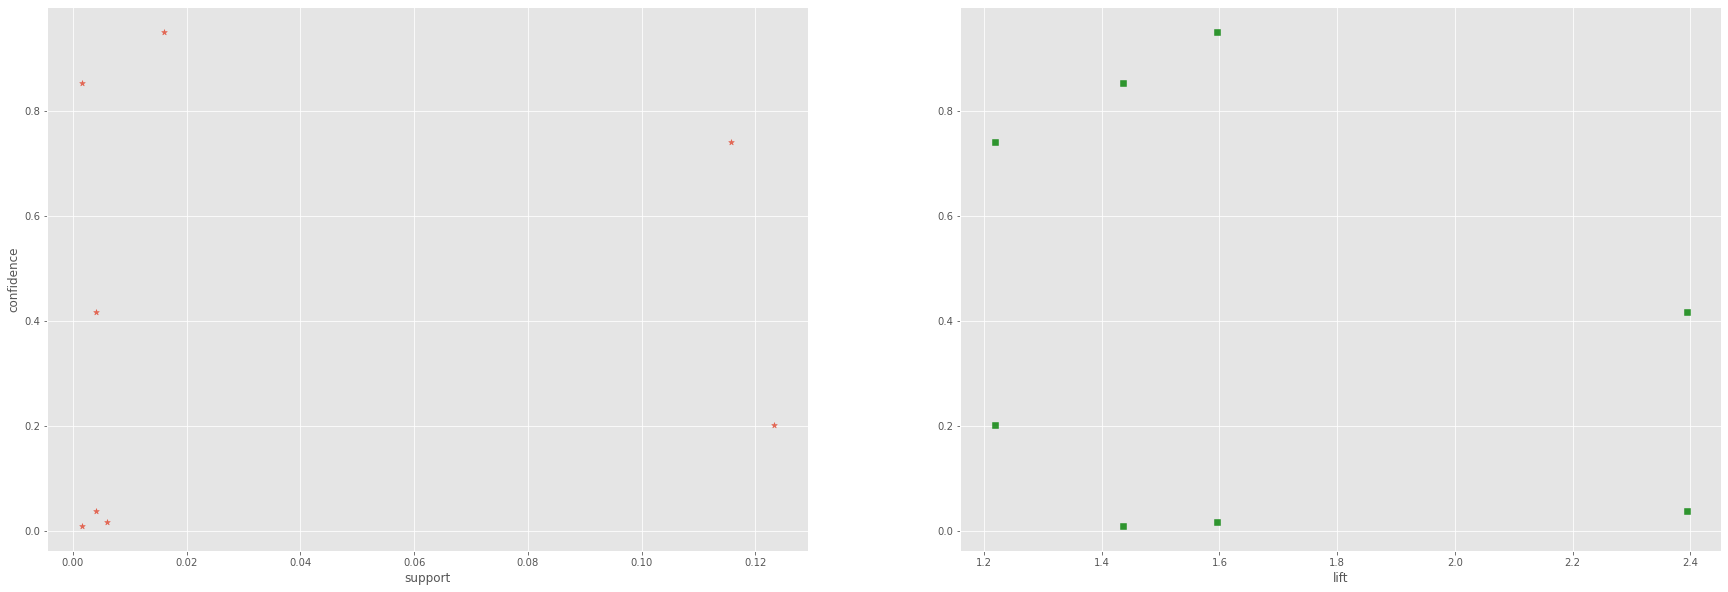

In [33]:
#plot association rules
plot_assoc_rules(rules[['support']].values,rules[['confidence']].values,rules[['lift']].values)

In [34]:
#fetch the most reliable association rules
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.max_colwidth', None):
    display(rules[ (rules['lift'] >= 1.5) &
        (rules['confidence'] >= 0.3)].sort_values(['lift'],ascending=False) )

antecedents             consequents  \
4  (NON_RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)      (RECYCLABLE ITEMS)   
3                                            (TIRES)  (NON_RECYCLABLE ITEMS)   

   antecedent support  consequent support   support  confidence      lift  \
4            0.015917            0.172887  0.006586    0.413793  2.393432   
3            0.011526            0.596597  0.010977    0.952381  1.596355   

   leverage  conviction  
4  0.003834    1.410958  
3  0.004101    8.471460

### Inference:
We see that the dataset for high income group has around 1800 records. To generate association rules, we keep a minimum support of 0.005.

The highest lift is 2.39 and confidence is 0.95

Since there were 8 association rules generated, to select the most frequent association rules, we choose a lift (>1.5 which is close to the 50% mark) and a confidence too (>0.3 which is close to the 50% mark)

### Conclusion for running Association Rules on the high income dataset:
Similar to assocition rules for the entire dataset, we see that if NON_RECYCLABLE ITEMS and HNS HEALTH AND SANITATION requests are raised, chances of RECYCLABLE ITEMS request are likely to also be raised. Also, requests on TIRES have chances of raising NON_RECYCLABLE ITEMS in a particular neighborhood profile area during a monthly timeframe.

## Mid income levels

In [35]:
#create a matrix of merge index and category with the values as sum of mid income requests(number of requests of 
# a particular category raised per month of a year for a particular neighborhood profile area) 
mid_inc_basket = (requests[requests['PREDOMINANT_INCOME_BRACKET']=='Mid']
          .groupby(['MERGE_INDEX','REQUEST_CAT'])['REQ_COUNT']
          .sum().unstack().reset_index().fillna(0)
          .set_index('MERGE_INDEX'))
mid_inc_basket.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
MERGE_INDEX                                                             
10_2016_10            3.0                     2.0                 0.0   
10_2016_100           2.0                     0.0                 0.0   
10_2016_101           0.0                     0.0                 0.0   
10_2016_102           0.0                     0.0                 0.0   
10_2016_103           1.0                     0.0                 0.0   
10_2016_105           0.0                     1.0                 0.0   
10_2016_106           0.0                     0.0                 0.0   
10_2016_107           1.0                     0.0                 0.0   
10_2016_108           0.0                     0.0                 0.0   
10_2016_109           0.0                     0.0                 0.0   
10_2016_11            2.0                     0.0                 0.0   
10_2016_110           0.0                     0.0                 0.0   
10_2016_111           0.0                     0.0                 0.0   
10_2016_112           0.0                     0.0                 0.0   
10_2016_113           3.0                     0.0                 0.0   
10_2016_114           0.0                     1.0                 0.0   
10_2016_115           0.0                     0.0                 0.0   
10_2016_116           4.0                     1.0                 0.0   
10_2016_117           3.0                     3.0                 0.0   
10_2016_118           0.0                     0.0                 0.0   

REQUEST_CAT  ANIMAL FOUND REPORT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  \
MERGE_INDEX                                                                    
10_2016_10                   0.0       0.0                   0.0         2.0   
10_2016_100                  0.0       0.0                   0.0         0.0   
10_2016_101                  0.0       0.0                   0.0         0.0   
10_2016_102                  0.0       0.0                   0.0         0.0   
10_2016_103                  0.0       0.0                   0.0         0.0   
10_2016_105                  0.0       0.0                   0.0         0.0   
10_2016_106                  0.0       0.0                   0.0         0.0   
10_2016_107                  0.0       0.0                   0.0         0.0   
10_2016_108                  0.0       0.0                   0.0         0.0   
10_2016_109                  0.0       0.0                   0.0         0.0   
10_2016_11                   0.0       1.0                   0.0         0.0   
10_2016_110                  0.0       0.0                   0.0         0.0   
10_2016_111                  0.0       0.0                   0.0         0.0   
10_2016_112                  0.0       0.0                   0.0         0.0   
10_2016_113                  0.0       0.0                   0.0         1.0   
10_2016_114                  0.0       0.0                   0.0         0.0   
10_2016_115                  0.0       1.0                   0.0         0.0   
10_2016_116                  0.0       1.0                   0.0         1.0   
10_2016_117                  0.0       0.0                   0.0         1.0   
10_2016_118                  0.0       0.0                   0.0         0.0   

REQUEST_CAT  CART  CLEANLINESS  COMPLAINT  ...  SW ONLY-DOOR HANGER LEFT  \
MERGE_INDEX                                ...                             
10_2016_10   18.0          0.0        0.0  ...                       0.0   
10_2016_100   4.0          0.0        1.0  ...                       0.0   
10_2016_101   1.0          1.0        0.0  ...                       0.0   
10_2016_102   2.0          0.0        0.0  ...                       0.0   
10_2016_103   2.0          0.0        0.0  ...                       0.0   
10_2016_105   0.0          0.0        0.0  ...                       0.0   
10_2016_106   0.0       

In [36]:
mid_inc_basket.shape

(26072, 39)

In [37]:
#update the values in the mid_inc_basket_sets
mid_inc_basket_sets = mid_inc_basket.applymap(encode_units)
mid_inc_basket_sets.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
MERGE_INDEX                                                             
10_2016_10              1                       1                   0   
10_2016_100             1                       0                   0   
10_2016_101             0                       0                   0   
10_2016_102             0                       0                   0   
10_2016_103             1                       0                   0   
10_2016_105             0                       1                   0   
10_2016_106             0                       0                   0   
10_2016_107             1                       0                   0   
10_2016_108             0                       0                   0   
10_2016_109             0                       0                   0   
10_2016_11              1                       0                   0   
10_2016_110             0                       0                   0   
10_2016_111             0                       0                   0   
10_2016_112             0                       0                   0   
10_2016_113             1                       0                   0   
10_2016_114             0                       1                   0   
10_2016_115             0                       0                   0   
10_2016_116             1                       1                   0   
10_2016_117             1                       1                   0   
10_2016_118             0                       0                   0   

REQUEST_CAT  ANIMAL FOUND REPORT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  \
MERGE_INDEX                                                                    
10_2016_10                     0         0                     0           1   
10_2016_100                    0         0                     0           0   
10_2016_101                    0         0                     0           0   
10_2016_102                    0         0                     0           0   
10_2016_103                    0         0                     0           0   
10_2016_105                    0         0                     0           0   
10_2016_106                    0         0                     0           0   
10_2016_107                    0         0                     0           0   
10_2016_108                    0         0                     0           0   
10_2016_109                    0         0                     0           0   
10_2016_11                     0         1                     0           0   
10_2016_110                    0         0                     0           0   
10_2016_111                    0         0                     0           0   
10_2016_112                    0         0                     0           0   
10_2016_113                    0         0                     0           1   
10_2016_114                    0         0                     0           0   
10_2016_115                    0         1                     0           0   
10_2016_116                    0         1                     0           1   
10_2016_117                    0         0                     0           1   
10_2016_118                    0         0                     0           0   

REQUEST_CAT  CART  CLEANLINESS  COMPLAINT  ...  SW ONLY-DOOR HANGER LEFT  \
MERGE_INDEX                                ...                             
10_2016_10      1            0          0  ...                         0   
10_2016_100     1            0          1  ...                         0   
10_2016_101     1            1          0  ...                         0   
10_2016_102     1            0          0  ...                         0   
10_2016_103     1            0          0  ...                         0   
10_2016_105     0            0          0  ...                         0   
10_2016_106     0       

In [38]:
#creating the frequest request sets. We use a minimum support of 0.1 to create 
# more number of frequent lists than seen above
rules=create_assoc_rules("lift",0.1,1,mid_inc_basket_sets)
rules.head(30)

antecedents                  consequents  \
0                  (BULKY ITEM)               (311 DOCUMENT)   
1                (311 DOCUMENT)                 (BULKY ITEM)   
2                        (CART)               (311 DOCUMENT)   
3                (311 DOCUMENT)                       (CART)   
4                   (COMPLAINT)               (311 DOCUMENT)   
5                (311 DOCUMENT)                  (COMPLAINT)   
6           (CUSTOMER FEEDBACK)               (311 DOCUMENT)   
7                (311 DOCUMENT)          (CUSTOMER FEEDBACK)   
8      (DEAD ANIMAL COLLECTION)               (311 DOCUMENT)   
9                (311 DOCUMENT)     (DEAD ANIMAL COLLECTION)   
10                    (GARBAGE)               (311 DOCUMENT)   
11               (311 DOCUMENT)                    (GARBAGE)   
12  (HNS HEALTH AND SANITATION)               (311 DOCUMENT)   
13               (311 DOCUMENT)  (HNS HEALTH AND SANITATION)   
14             (MISSED SERVICE)               (311 DOCUMENT)   
15               (311 DOCUMENT)             (MISSED SERVICE)   
16           (RECYCLABLE ITEMS)               (311 DOCUMENT)   
17               (311 DOCUMENT)           (RECYCLABLE ITEMS)   
18                  (RECYCLING)               (311 DOCUMENT)   
19               (311 DOCUMENT)                  (RECYCLING)   
20                      (TIRES)               (311 DOCUMENT)   
21               (311 DOCUMENT)                      (TIRES)   
22             (TRANSPORTATION)               (311 DOCUMENT)   
23               (311 DOCUMENT)             (TRANSPORTATION)   
24                 (VIOLATIONS)               (311 DOCUMENT)   
25               (311 DOCUMENT)                 (VIOLATIONS)   
26  (WEATHER AND ENVIRONMENTAL)               (311 DOCUMENT)   
27               (311 DOCUMENT)  (WEATHER AND ENVIRONMENTAL)   
28                 (YARD WASTE)               (311 DOCUMENT)   
29               (311 DOCUMENT)                 (YARD WASTE)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.218855            0.480822  0.125882    0.575184  1.196251   
1             0.480822            0.218855  0.125882    0.261806  1.196251   
2             0.705278            0.480822  0.365986    0.518925  1.079246   
3             0.480822            0.705278  0.365986    0.761168  1.079246   
4             0.250997            0.480822  0.143295    0.570905  1.187351   
5             0.480822            0.250997  0.143295    0.298022  1.187351   
6             0.204779            0.480822  0.112956    0.551601  1.147204   
7             0.480822            0.204779  0.112956    0.234923  1.147204   
8             0.263002            0.480822  0.148780    0.565699  1.176525   
9             0.480822            0.263002  0.148780    0.309429  1.176525   
10            0.493518            0.480822  0.270175    0.547447  1.138564   
11            0.480822            0.493518  0.270175    0.561902  1.138564   
12            0.615143            0.480822  0.322376    0.524068  1.089941   
13            0.480822            0.615143  0.322376    0.670469  1.089941   
14            0.515342            0.480822  0.268679    0.521361  1.084310   
15            0.480822            0.515342  0.268679    0.558791  1.084310   
16            0.802547            0.480822  0.398550    0.496607  1.032828   
17            0.480822            0.802547  0.398550    0.828893  1.032828   
18            0.398857            0.480822  0.219814    0.551111  1.146184   
19            0.480822            0.398857  0.219814    0.457163  1.146184   
20            0.303736            0.480822  0.178889    0.588963  1.224908   
21            0.480822            0.303736  0.178889    0.372049  1.224908   
22            0.640841            0.480822  0.335379    0.523342  1.088431   
23            0.480822            0.640841  0.335379    0.697511  1.088431   
24            0.275583            0.480822  0.160172    0.581211  1.208785   
25     

In [39]:
rules.tail(30)

antecedents  \
109400  (RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
109401             (MISSED SERVICE, RECYCLABLE ITEMS)   
109402                  (RECYCLING, RECYCLABLE ITEMS)   
109403             (RECYCLABLE ITEMS, TRANSPORTATION)   
109404                       (CART, RECYCLABLE ITEMS)   
109405               (RECYCLABLE ITEMS, 311 DOCUMENT)   
109406    (MISSED SERVICE, HNS HEALTH AND SANITATION)   
109407         (RECYCLING, HNS HEALTH AND SANITATION)   
109408    (HNS HEALTH AND SANITATION, TRANSPORTATION)   
109409              (CART, HNS HEALTH AND SANITATION)   
109410      (HNS HEALTH AND SANITATION, 311 DOCUMENT)   
109411                    (MISSED SERVICE, RECYCLING)   
109412               (MISSED SERVICE, TRANSPORTATION)   
109413                         (MISSED SERVICE, CART)   
109414                 (MISSED SERVICE, 311 DOCUMENT)   
109415                    (RECYCLING, TRANSPORTATION)   
109416                              (RECYCLING, CART)   
109417                      (RECYCLING, 311 DOCUMENT)   
109418                         (CART, TRANSPORTATION)   
109419                 (311 DOCUMENT, TRANSPORTATION)   
109420                           (CART, 311 DOCUMENT)   
109421                         (NON_RECYCLABLE ITEMS)   
109422                                      (GARBAGE)   
109423                             (RECYCLABLE ITEMS)   
109424                    (HNS HEALTH AND SANITATION)   
109425                               (MISSED SERVICE)   
109426                                    (RECYCLING)   
109427                               (TRANSPORTATION)   
109428                                         (CART)   
109429                                 (311 DOCUMENT)   

                                              consequents  antecedent support  \
109400  (NON_RECYCLABLE ITEMS, GARBAGE, 311 DOCUMENT, ...            0.589521   
109401  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.492406   
109402  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.389076   
109403  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.608967   
109404  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.682648   
109405  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.398550   
109406  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.390112   
109407  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.313631   
109408  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.491945   
109409  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.538470   
109410  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.322376   
109411  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.296141   
109412  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.405608   
109413  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.450330   
109414  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.268679   
109415  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.329587   
109416  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.367022   
109417  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.219814   
109418  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.555845   
109419  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.335379   
109420  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.365986   
109421  (GARBAGE, RECYCLABLE ITEMS, HNS HEALTH AND SAN...            0.867712   
109422  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, HNS H...            0.493518   
109423  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.802547   
109424  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.615143   
109425  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.515342   
109426  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.398857   
109427

In [40]:
rules.describe()

antecedent support  consequent support        support     confidence  \
count       109430.000000       109430.000000  109430.000000  109430.000000   
mean             0.334647            0.334647       0.134331       0.510306   
std              0.186045            0.186045       0.043548       0.246683   
min              0.100031            0.100031       0.100031       0.115281   
25%              0.186522            0.186522       0.107778       0.303690   
50%              0.276005            0.276005       0.119899       0.464131   
75%              0.449486            0.449486       0.144216       0.699922   
max              0.867712            0.867712       0.801856       1.000000   

                lift       leverage    conviction  
count  109430.000000  109430.000000  1.094300e+05  
mean        1.563002       0.045610           inf  
std         0.194869       0.012829           NaN  
min         1.032828       0.008010  1.010858e+00  
25%         1.420793       0.038495  1.160344e+00  
50%         1.569577       0.045206  1.342379e+00  
75%         1.697943       0.052044  1.874787e+00  
max         2.156804       0.117762           inf

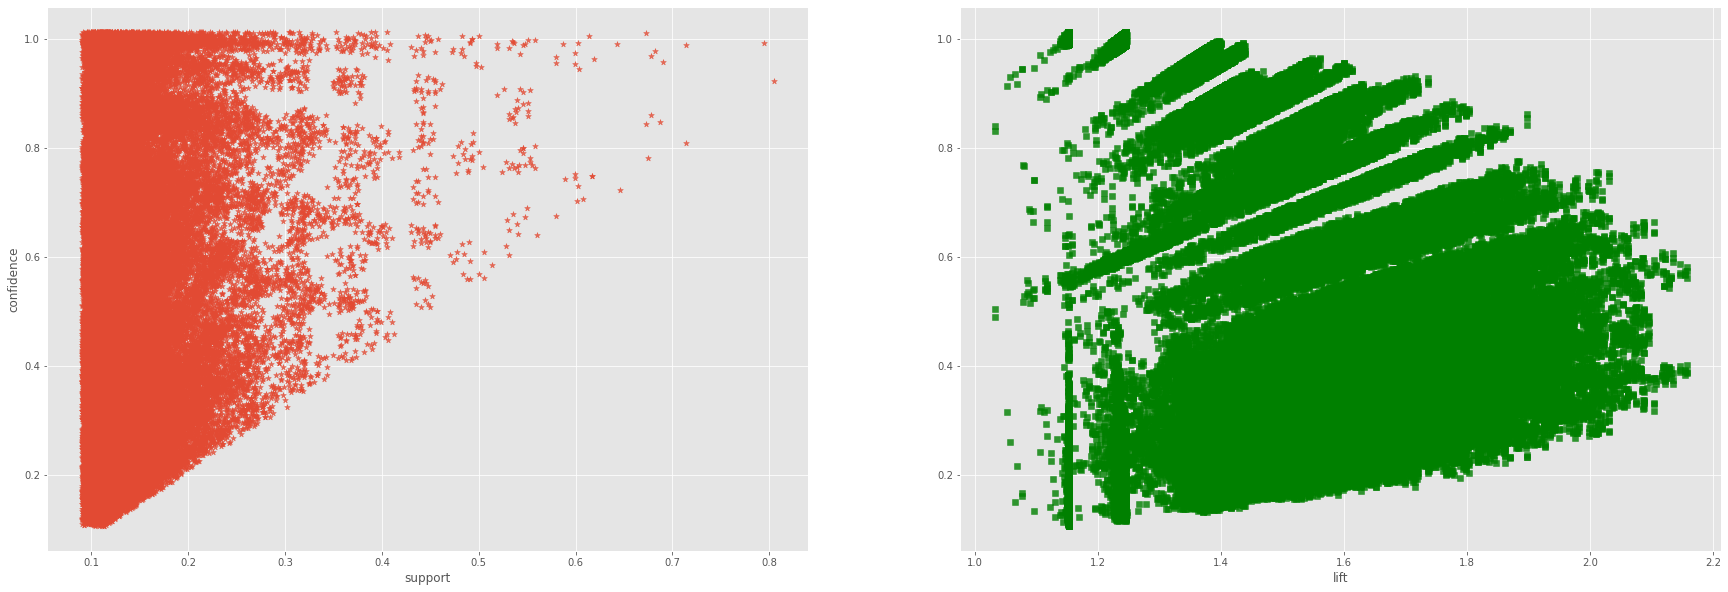

In [41]:
#plot association rules
plot_assoc_rules(rules[['support']].values,rules[['confidence']].values,rules[['lift']].values)

In [42]:
#fetch the most reliable association rules
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.max_colwidth', None):
    display(rules[ (rules['lift'] >= 2) &
        (rules['confidence'] >= 0.7)].sort_values(['lift'],ascending=False) )

antecedents  \
96589                                           (RECYCLING, YARD WASTE, GARBAGE)   
108252                    (NON_RECYCLABLE ITEMS, YARD WASTE, GARBAGE, RECYCLING)   
108343                                          (RECYCLING, YARD WASTE, GARBAGE)   
92558                                           (RECYCLING, YARD WASTE, GARBAGE)   
106221                    (NON_RECYCLABLE ITEMS, YARD WASTE, GARBAGE, RECYCLING)   
106312                                          (RECYCLING, YARD WASTE, GARBAGE)   
108286                        (RECYCLING, YARD WASTE, GARBAGE, RECYCLABLE ITEMS)   
96553                         (RECYCLING, YARD WASTE, GARBAGE, RECYCLABLE ITEMS)   
108195  (NON_RECYCLABLE ITEMS, YARD WASTE, GARBAGE, RECYCLABLE ITEMS, RECYCLING)   
96477                                           (RECYCLING, YARD WASTE, GARBAGE)   
96427                     (NON_RECYCLABLE ITEMS, YARD WASTE, GARBAGE, RECYCLING)   
66418                                           (RECYCLING, YARD WASTE, GARBAGE)   
106255                        (RECYCLING, YARD WASTE, GARBAGE, RECYCLABLE ITEMS)   
92522                         (RECYCLING, YARD WASTE, GARBAGE, RECYCLABLE ITEMS)   
106164  (NON_RECYCLABLE ITEMS, YARD WASTE, GARBAGE, RECYCLABLE ITEMS, RECYCLING)   
91690                                           (RECYCLING, YARD WASTE, GARBAGE)   
91640                     (NON_RECYCLABLE ITEMS, YARD WASTE, GARBAGE, RECYCLING)   
62203                                           (RECYCLING, YARD WASTE, GARBAGE)   

                                                                                      consequents  \
96589                                    (MISSED SERVICE, CART, RECYCLABLE ITEMS, TRANSPORTATION)   
108252                                   (MISSED SERVICE, CART, RECYCLABLE ITEMS, TRANSPORTATION)   
108343             (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, MISSED SERVICE, CART, TRANSPORTATION)   
92558                         (MISSED SERVICE, CART, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
106221                        (MISSED SERVICE, CART, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
106312  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION, MISSED SERVICE, CART)   
108286                               (NON_RECYCLABLE ITEMS, MISSED SERVICE, CART, TRANSPORTATION)   
96553                                                      (MISSED SERVICE, CART, TRANSPORTATION)   
108195                                                     (MISSED SERVICE, CART, TRANSPORTATION)   
96477                                (NON_RECYCLABLE ITEMS, MISSED SERVICE, CART, TRANSPORTATION)   
96427                                                      (MISSED SERVICE, CART, TRANSPORTATION)   
66418                                                      (MISSED SERVICE, CART, TRANSPORTATION)   
106255                    (NON_RECYCLABLE ITEMS, MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   
92522                                           (MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   
106164                                          (MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   
91690                     (NON_RECYCLABLE ITEMS, MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   
91640                                           (MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   
62203                                           (MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   

        antecedent support  consequent support   support  confidence  \
96589             0.141569            0.364567  0.104825    0.740450   
108252            0.141569            0.364567  0.104825    0.740450   
108343            0.141569            0.364567  0.104825    0.740450   
92558             0.141569            0.353099  0.100951    0.713086   
106221            0.141569            0.353099  0.100951    0.713086   
106312            0.141569            0.353099  0.100951    0.713086   
108286            0.140726            0.370052  

### Inference:
We see a lot of similarities in the association rules generated by mid income group and the ones generated on the entire dataset. 

The highest lift is 2.15 and we also have some perfect confidence scores of 1.

To select the most frequent association rules, we choose a high lift (>2) and a high confidence too (>0.7 which is close to the 75% mark)

### Conclusion for running Association Rules on the mid income dataset:
We see that if GARBAGE, YARD WASTE, RECYCLING requests are raised, chances of MISSED SERVICE, RECYCLABLE ITEMS, CART, TRANSPORTATION are likely to also be raised in a particular neighborhood profile area during a monthly timeframe. We also see the above requests in combination with NON_RECYCLABLE ITEMS and RECYCLABLE ITEMS requests.

One difference we observe is, we don't see VIOLATIONS requests as part of the association rules for mid income group 

## Low income levels

In [43]:
#create a matrix of merge index and category with the values as sum of low income requests(number of requests of 
# a particular category raised per month of a year for a particular neighborhood profile area) 
low_inc_basket = (requests[requests['PREDOMINANT_INCOME_BRACKET']=='Low']
          .groupby(['MERGE_INDEX','REQUEST_CAT'])['REQ_COUNT']
          .sum().unstack().reset_index().fillna(0)
          .set_index('MERGE_INDEX'))
low_inc_basket.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
MERGE_INDEX                                                             
10_2016_113           0.0                     0.0                 0.0   
10_2016_124           0.0                     0.0                 0.0   
10_2016_125           0.0                     0.0                 0.0   
10_2016_126           0.0                     0.0                 0.0   
10_2016_138           1.0                     0.0                 0.0   
10_2016_153           0.0                     0.0                 0.0   
10_2016_157           2.0                     0.0                 0.0   
10_2016_158           0.0                     0.0                 0.0   
10_2016_182           0.0                     0.0                 0.0   
10_2016_190           0.0                     0.0                 0.0   
10_2016_21            2.0                     0.0                 0.0   
10_2016_215           0.0                     0.0                 0.0   
10_2016_22            0.0                     0.0                 0.0   
10_2016_241           0.0                     0.0                 0.0   
10_2016_283           0.0                     0.0                 0.0   
10_2016_295           0.0                     0.0                 0.0   
10_2016_301           0.0                     0.0                 0.0   
10_2016_311           0.0                     0.0                 0.0   
10_2016_314           0.0                     0.0                 0.0   
10_2016_333           0.0                     0.0                 0.0   

REQUEST_CAT  ANIMAL FOUND REPORT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  \
MERGE_INDEX                                                                    
10_2016_113                  0.0       0.0                   0.0         0.0   
10_2016_124                  0.0       0.0                   0.0         0.0   
10_2016_125                  0.0       0.0                   0.0         0.0   
10_2016_126                  0.0       0.0                   0.0         0.0   
10_2016_138                  0.0       0.0                   0.0         0.0   
10_2016_153                  0.0       0.0                   0.0         0.0   
10_2016_157                  0.0       0.0                   0.0         0.0   
10_2016_158                  0.0       0.0                   0.0         0.0   
10_2016_182                  0.0       0.0                   0.0         0.0   
10_2016_190                  0.0       0.0                   0.0         0.0   
10_2016_21                   0.0       0.0                   0.0         0.0   
10_2016_215                  0.0       0.0                   0.0         0.0   
10_2016_22                   0.0       0.0                   0.0         0.0   
10_2016_241                  0.0       0.0                   0.0         0.0   
10_2016_283                  0.0       0.0                   0.0         0.0   
10_2016_295                  0.0       0.0                   0.0         0.0   
10_2016_301                  0.0       0.0                   0.0         0.0   
10_2016_311                  0.0       0.0                   0.0         0.0   
10_2016_314                  0.0       0.0                   0.0         0.0   
10_2016_333                  0.0       0.0                   0.0         0.0   

REQUEST_CAT  CART  CLEANLINESS  COMPLAINT  ...  SW ONLY-DOOR HANGER LEFT  \
MERGE_INDEX                                ...                             
10_2016_113   0.0          0.0        0.0  ...                       0.0   
10_2016_124   0.0          0.0        0.0  ...                       0.0   
10_2016_125   0.0          0.0        0.0  ...                       0.0   
10_2016_126   0.0          0.0        0.0  ...                       0.0   
10_2016_138   0.0          0.0        0.0  ...                       0.0   
10_2016_153   0.0          0.0        0.0  ...                       0.0   
10_2016_157   2.0       

In [44]:
low_inc_basket.shape

(1473, 38)

In [45]:
#update the values in the low_inc_basket
low_inc_basket_sets = low_inc_basket.applymap(encode_units)
low_inc_basket_sets.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
MERGE_INDEX                                                             
10_2016_113             0                       0                   0   
10_2016_124             0                       0                   0   
10_2016_125             0                       0                   0   
10_2016_126             0                       0                   0   
10_2016_138             1                       0                   0   
10_2016_153             0                       0                   0   
10_2016_157             1                       0                   0   
10_2016_158             0                       0                   0   
10_2016_182             0                       0                   0   
10_2016_190             0                       0                   0   
10_2016_21              1                       0                   0   
10_2016_215             0                       0                   0   
10_2016_22              0                       0                   0   
10_2016_241             0                       0                   0   
10_2016_283             0                       0                   0   
10_2016_295             0                       0                   0   
10_2016_301             0                       0                   0   
10_2016_311             0                       0                   0   
10_2016_314             0                       0                   0   
10_2016_333             0                       0                   0   

REQUEST_CAT  ANIMAL FOUND REPORT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  \
MERGE_INDEX                                                                    
10_2016_113                    0         0                     0           0   
10_2016_124                    0         0                     0           0   
10_2016_125                    0         0                     0           0   
10_2016_126                    0         0                     0           0   
10_2016_138                    0         0                     0           0   
10_2016_153                    0         0                     0           0   
10_2016_157                    0         0                     0           0   
10_2016_158                    0         0                     0           0   
10_2016_182                    0         0                     0           0   
10_2016_190                    0         0                     0           0   
10_2016_21                     0         0                     0           0   
10_2016_215                    0         0                     0           0   
10_2016_22                     0         0                     0           0   
10_2016_241                    0         0                     0           0   
10_2016_283                    0         0                     0           0   
10_2016_295                    0         0                     0           0   
10_2016_301                    0         0                     0           0   
10_2016_311                    0         0                     0           0   
10_2016_314                    0         0                     0           0   
10_2016_333                    0         0                     0           0   

REQUEST_CAT  CART  CLEANLINESS  COMPLAINT  ...  SW ONLY-DOOR HANGER LEFT  \
MERGE_INDEX                                ...                             
10_2016_113     0            0          0  ...                         0   
10_2016_124     0            0          0  ...                         0   
10_2016_125     0            0          0  ...                         0   
10_2016_126     0            0          0  ...                         0   
10_2016_138     0            0          0  ...                         0   
10_2016_153     0            0          0  ...                         0   
10_2016_157     1       

In [46]:
#creating the frequest request sets. We use a minimum support of 0.1 to create 
# more number of frequent lists than seen above
rules=create_assoc_rules("lift",0.1,1,low_inc_basket_sets)
rules.head(30)

antecedents                  consequents  \
0                        (CART)               (311 DOCUMENT)   
1                (311 DOCUMENT)                       (CART)   
2                     (GARBAGE)               (311 DOCUMENT)   
3                (311 DOCUMENT)                    (GARBAGE)   
4   (HNS HEALTH AND SANITATION)               (311 DOCUMENT)   
5                (311 DOCUMENT)  (HNS HEALTH AND SANITATION)   
6              (MISSED SERVICE)               (311 DOCUMENT)   
7                (311 DOCUMENT)             (MISSED SERVICE)   
8        (NON_RECYCLABLE ITEMS)               (311 DOCUMENT)   
9                (311 DOCUMENT)       (NON_RECYCLABLE ITEMS)   
10           (RECYCLABLE ITEMS)               (311 DOCUMENT)   
11               (311 DOCUMENT)           (RECYCLABLE ITEMS)   
12             (TRANSPORTATION)               (311 DOCUMENT)   
13               (311 DOCUMENT)             (TRANSPORTATION)   
14                    (GARBAGE)                       (CART)   
15                       (CART)                    (GARBAGE)   
16                       (CART)  (HNS HEALTH AND SANITATION)   
17  (HNS HEALTH AND SANITATION)                       (CART)   
18             (MISSED SERVICE)                       (CART)   
19                       (CART)             (MISSED SERVICE)   
20       (NON_RECYCLABLE ITEMS)                       (CART)   
21                       (CART)       (NON_RECYCLABLE ITEMS)   
22                       (CART)           (RECYCLABLE ITEMS)   
23           (RECYCLABLE ITEMS)                       (CART)   
24                  (RECYCLING)                       (CART)   
25                       (CART)                  (RECYCLING)   
26                       (CART)                      (TIRES)   
27                      (TIRES)                       (CART)   
28                       (CART)             (TRANSPORTATION)   
29             (TRANSPORTATION)                       (CART)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.319756            0.191446  0.152071    0.475584  2.484167   
1             0.191446            0.319756  0.152071    0.794326  2.484167   
2             0.222675            0.191446  0.112016    0.503049  2.627627   
3             0.191446            0.222675  0.112016    0.585106  2.627627   
4             0.395112            0.191446  0.164291    0.415808  2.171931   
5             0.191446            0.395112  0.164291    0.858156  2.171931   
6             0.228106            0.191446  0.101154    0.443452  2.316331   
7             0.191446            0.228106  0.101154    0.528369  2.316331   
8             0.702648            0.191446  0.180584    0.257005  1.342440   
9             0.191446            0.702648  0.180584    0.943262  1.342440   
10            0.467753            0.191446  0.175153    0.374456  1.955934   
11            0.191446            0.467753  0.175153    0.914894  1.955934   
12            0.337407            0.191446  0.147318    0.436620  2.280641   
13            0.191446            0.337407  0.147318    0.769504  2.280641   
14            0.222675            0.319756  0.166327    0.746951  2.336007   
15            0.319756            0.222675  0.166327    0.520170  2.336007   
16            0.319756            0.395112  0.254582    0.796178  2.015070   
17            0.395112            0.319756  0.254582    0.644330  2.015070   
18            0.228106            0.319756  0.152071    0.666667  2.084926   
19            0.319756            0.228106  0.152071    0.475584  2.084926   
20            0.702648            0.319756  0.285811    0.406763  1.272107   
21            0.319756            0.702648  0.285811    0.893843  1.272107   
22            0.319756            0.467753  0.273591    0.855626  1.829227   
23            0.467753            0.319756  0.273591    0.584906  1.829227   
24            0.153428            0.319756  0.116768    0.761062  2.380136   
25     

In [47]:
rules.tail(30)

antecedents  \
2700               (CART, VIOLATIONS, RECYCLABLE ITEMS)   
2701     (VIOLATIONS, RECYCLABLE ITEMS, TRANSPORTATION)   
2702      (VIOLATIONS, CART, HNS HEALTH AND SANITATION)   
2703  (VIOLATIONS, HNS HEALTH AND SANITATION, TRANSP...   
2704                 (VIOLATIONS, CART, TRANSPORTATION)   
2705  (CART, RECYCLABLE ITEMS, HNS HEALTH AND SANITA...   
2706  (RECYCLABLE ITEMS, HNS HEALTH AND SANITATION, ...   
2707           (CART, RECYCLABLE ITEMS, TRANSPORTATION)   
2708  (CART, HNS HEALTH AND SANITATION, TRANSPORTATION)   
2709                 (NON_RECYCLABLE ITEMS, VIOLATIONS)   
2710           (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS)   
2711  (NON_RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
2712                       (NON_RECYCLABLE ITEMS, CART)   
2713             (NON_RECYCLABLE ITEMS, TRANSPORTATION)   
2714                     (VIOLATIONS, RECYCLABLE ITEMS)   
2715            (VIOLATIONS, HNS HEALTH AND SANITATION)   
2716                                 (VIOLATIONS, CART)   
2717                       (VIOLATIONS, TRANSPORTATION)   
2718      (RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
2719                           (CART, RECYCLABLE ITEMS)   
2720                 (RECYCLABLE ITEMS, TRANSPORTATION)   
2721                  (CART, HNS HEALTH AND SANITATION)   
2722        (HNS HEALTH AND SANITATION, TRANSPORTATION)   
2723                             (CART, TRANSPORTATION)   
2724                             (NON_RECYCLABLE ITEMS)   
2725                                       (VIOLATIONS)   
2726                                 (RECYCLABLE ITEMS)   
2727                        (HNS HEALTH AND SANITATION)   
2728                                             (CART)   
2729                                   (TRANSPORTATION)   

                                            consequents  antecedent support  \
2700  (NON_RECYCLABLE ITEMS, HNS HEALTH AND SANITATI...            0.130346   
2701  (NON_RECYCLABLE ITEMS, CART, HNS HEALTH AND SA...            0.125594   
2702  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, TRANS...            0.124915   
2703     (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS)            0.122878   
2704  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, HNS H...            0.112695   
2705  (NON_RECYCLABLE ITEMS, VIOLATIONS, TRANSPORTAT...            0.247794   
2706           (NON_RECYCLABLE ITEMS, VIOLATIONS, CART)            0.246436   
2707  (NON_RECYCLABLE ITEMS, VIOLATIONS, HNS HEALTH ...            0.217923   
2708  (NON_RECYCLABLE ITEMS, VIOLATIONS, RECYCLABLE ...            0.209776   
2709  (CART, RECYCLABLE ITEMS, HNS HEALTH AND SANITA...            0.164969   
2710  (VIOLATIONS, CART, HNS HEALTH AND SANITATION, ...            0.433809   
2711  (CART, VIOLATIONS, RECYCLABLE ITEMS, TRANSPORT...            0.338764   
2712  (VIOLATIONS, RECYCLABLE ITEMS, HNS HEALTH AND ...            0.285811   
2713  (CART, VIOLATIONS, RECYCLABLE ITEMS, HNS HEALT...            0.284453   
2714  (NON_RECYCLABLE ITEMS, CART, HNS HEALTH AND SA...            0.156823   
2715  (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS,...            0.146640   
2716  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, HNS H...            0.133062   
2717  (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS,...            0.135777   
2718  (NON_RECYCLABLE ITEMS, VIOLATIONS, CART, TRANS...            0.321792   
2719  (NON_RECYCLABLE ITEMS, VIOLATIONS, HNS HEALTH ...            0.273591   
2720  (NON_RECYCLABLE ITEMS, VIOLATIONS, CART, HNS H...            0.273591   
2721  (NON_RECYCLABLE ITEMS, VIOLATIONS, RECYCLABLE ...            0.254582   
2722  (NON_RECYCLABLE ITEMS, CART, VIOLATIONS, RECYC...            0.257298   
2723  (NON_RECYCLABLE ITEMS, VIOLATIONS, RECYCLABLE ...            0.224711   
2724  (VIOLATIONS, RECYCLABLE ITEMS, HNS HEALTH AND ...            0.702648   
2725  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, HNS H...            0.196877   
2726  (NON_RECYCLABLE ITEMS, VIOLATIONS, HNS HEALTH ...            0.467753   
27

In [48]:
rules.describe()

antecedent support  consequent support      support   confidence  \
count         2730.000000         2730.000000  2730.000000  2730.000000   
mean             0.256817            0.256817     0.132261     0.623227   
std              0.140251            0.140251     0.035306     0.245443   
min              0.100475            0.100475     0.100475     0.142995   
25%              0.152071            0.152071     0.109301     0.419980   
50%              0.222675            0.222675     0.122200     0.611729   
75%              0.319756            0.319756     0.139172     0.846927   
max              0.702648            0.702648     0.433809     1.000000   

              lift     leverage   conviction  
count  2730.000000  2730.000000  2730.000000  
mean      2.557275     0.076528          inf  
std       0.522581     0.020556          NaN  
min       1.192534     0.022721     1.037732  
25%       2.259742     0.067692     1.452210  
50%       2.661287     0.074980     1.983586  
75%       2.977253     0.085913     4.380907  
max       3.433828     0.161976          inf

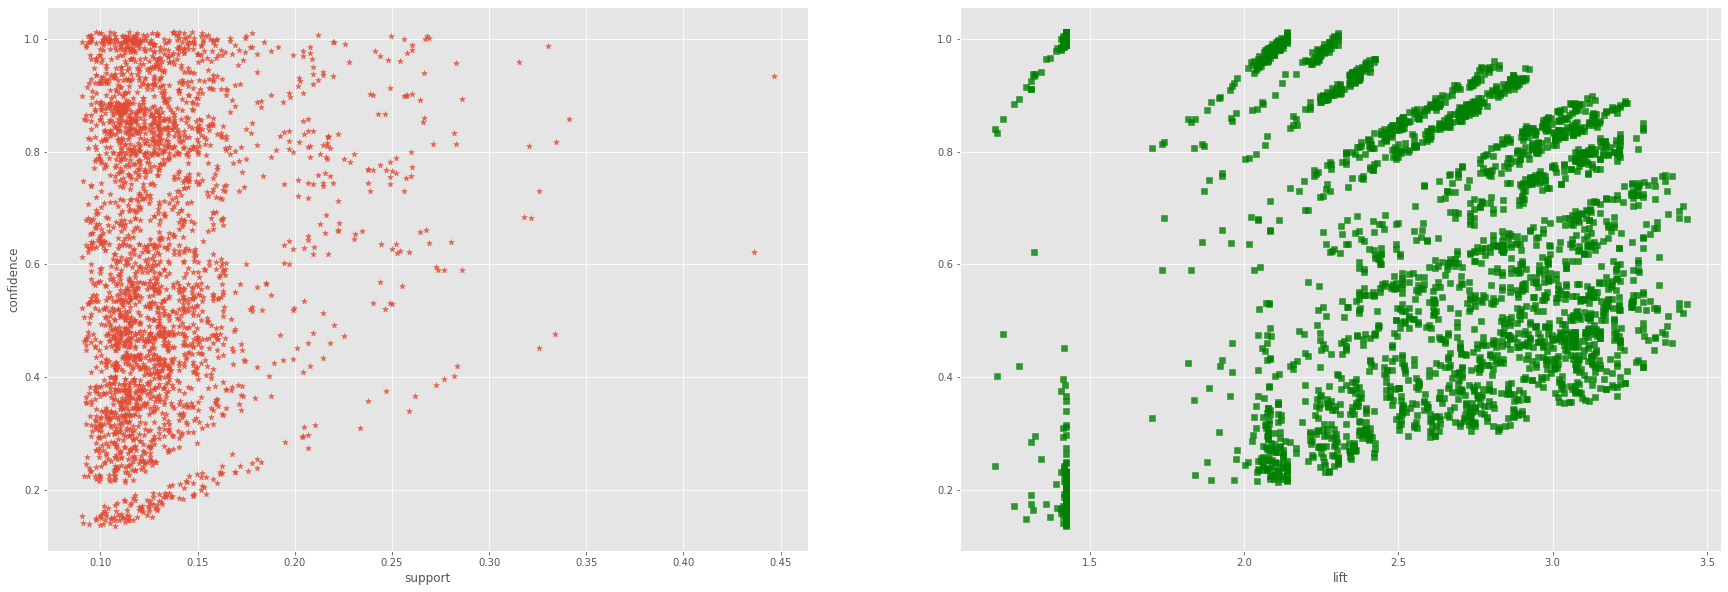

In [49]:
#plot association rules
plot_assoc_rules(rules[['support']].values,rules[['confidence']].values,rules[['lift']].values)

In [50]:
#fetch the most reliable association rules
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.max_colwidth', None):
    display(rules[ (rules['lift'] >= 3.1) &
        (rules['confidence'] >= 0.85)].sort_values(['lift'],ascending=False) )

antecedents  \
2444                                           (RECYCLING, HNS HEALTH AND SANITATION)   
2430                     (NON_RECYCLABLE ITEMS, RECYCLING, HNS HEALTH AND SANITATION)   
1563                                           (RECYCLING, HNS HEALTH AND SANITATION)   
2084                                           (RECYCLING, HNS HEALTH AND SANITATION)   
2264                                                                (RECYCLING, CART)   
1268                                                                (RECYCLING, CART)   
2250                                          (NON_RECYCLABLE ITEMS, RECYCLING, CART)   
2265                                                      (RECYCLING, TRANSPORTATION)   
1074                                           (RECYCLING, HNS HEALTH AND SANITATION)   
2070                     (NON_RECYCLABLE ITEMS, RECYCLING, HNS HEALTH AND SANITATION)   
1270                                                      (RECYCLING, TRANSPORTATION)   
2251                                (NON_RECYCLABLE ITEMS, RECYCLING, TRANSPORTATION)   
2678    (NON_RECYCLABLE ITEMS, VIOLATIONS, HNS HEALTH AND SANITATION, TRANSPORTATION)   
2703                          (VIOLATIONS, HNS HEALTH AND SANITATION, TRANSPORTATION)   
2520                        (311 DOCUMENT, HNS HEALTH AND SANITATION, TRANSPORTATION)   
2579                             (GARBAGE, HNS HEALTH AND SANITATION, TRANSPORTATION)   
2578                                       (GARBAGE, CART, HNS HEALTH AND SANITATION)   
2643                                (MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   
670                                                           (GARBAGE, 311 DOCUMENT)   
2043                                (MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   
2553                 (NON_RECYCLABLE ITEMS, GARBAGE, CART, HNS HEALTH AND SANITATION)   
1890                                       (GARBAGE, CART, HNS HEALTH AND SANITATION)   
2618          (NON_RECYCLABLE ITEMS, MISSED SERVICE, CART, HNS HEALTH AND SANITATION)   
2191                          (VIOLATIONS, HNS HEALTH AND SANITATION, TRANSPORTATION)   
2495  (NON_RECYCLABLE ITEMS, 311 DOCUMENT, HNS HEALTH AND SANITATION, TRANSPORTATION)   
1714                        (TRANSPORTATION, HNS HEALTH AND SANITATION, 311 DOCUMENT)   
2433                         (RECYCLING, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION)   
2554       (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND SANITATION, TRANSPORTATION)   
1891                             (GARBAGE, HNS HEALTH AND SANITATION, TRANSPORTATION)   
2128                    (NON_RECYCLABLE ITEMS, VIOLATIONS, HNS HEALTH AND SANITATION)   
2685        (VIOLATIONS, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION, TRANSPORTATION)   
1537                                           (RECYCLING, HNS HEALTH AND SANITATION)   
2253                                              (RECYCLING, CART, RECYCLABLE ITEMS)   

                                                   consequents  \
2444  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, TRANSPORTATION)   
2430                        (RECYCLABLE ITEMS, TRANSPORTATION)   
1563                        (RECYCLABLE ITEMS, TRANSPORTATION)   
2084            (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS)   
2264  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, TRANSPORTATION)   
1268                        (RECYCLABLE ITEMS, TRANSPORTATION)   
2250                        (RECYCLABLE ITEMS, TRANSPORTATION)   
2265            (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS)   
1074                                  (RECYCLABLE ITEMS, CART)   
2070                                  (CART, RECYCLABLE ITEMS)   
1270                                  (RECYCLABLE ITEMS, CART)   
2251                                  (CART, RECYCLABLE ITEMS)   
2678                                  (CART, RECYCLABLE ITEMS)   
2703            (NON_RECYCLABLE ITEMS, CART, RECYCLABLE ITEMS)   
2520            (NON_RECYCLABLE ITEMS, CART, RECYCLABLE I

### Inference:
Again, we see a lot of similarities in the association rules generated by low income group, mid income group and the ones generated on the entire dataset even though the count of low income basket records is around 1450. 

The highest lift is 3.43 and we also have some perfect confidence scores of 1.

To select the most frequent association rules, we choose a high lift (>3.1) and a high confidence too (>0.85 which is close to the 75% mark)

### Conclusion for running Association Rules on the low income dataset:
We see that if HNS HEALTH AND SANITATION, RECYCLING requests are raised, chances of RECYCLABLE ITEMS, NON_RECYCLABLE ITEMS, TRANSPORTATION are likely to also be raised in a particular neighborhood profile area during a monthly timeframe. We also see the above requests in combination with CART, GARBAGE and MISSED SERVICE requests. 

We observe that association rules for low income group have some combinations of VIOLATIONS requests.

## Association Rules for mid & high crime index areas

In [51]:
#create a matrix of merge index and category with the values as sum of mid & high crime index requests(number of requests of 
# a particular category raised per month of a year for a particular neighborhood profile area) 
high_crime_basket = (requests[requests['CRIME_INDEX']!='Low']
          .groupby(['MERGE_INDEX','REQUEST_CAT'])['REQ_COUNT']
          .sum().unstack().reset_index().fillna(0)
          .set_index('MERGE_INDEX'))
high_crime_basket.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
MERGE_INDEX                                                             
10_2016_124           2.0                     0.0                 0.0   
10_2016_164           1.0                     0.0                 0.0   
10_2016_219           0.0                     0.0                 0.0   
10_2016_290           0.0                     0.0                 0.0   
10_2016_3             6.0                     2.0                 0.0   
10_2016_331           0.0                     0.0                 0.0   
10_2016_341           0.0                     0.0                 0.0   
10_2016_342           1.0                     1.0                 0.0   
10_2016_358           0.0                     0.0                 0.0   
10_2016_367           0.0                     1.0                 0.0   
10_2016_371           4.0                     1.0                 0.0   
10_2016_384           0.0                     0.0                 0.0   
10_2016_385           2.0                     0.0                 0.0   
10_2016_387           2.0                     0.0                 0.0   
10_2016_72            0.0                     1.0                 0.0   
10_2016_96            1.0                     0.0                 0.0   
10_2017_124           1.0                     0.0                 0.0   
10_2017_164           1.0                     0.0                 0.0   
10_2017_219           2.0                     0.0                 0.0   
10_2017_290           0.0                     0.0                 0.0   

REQUEST_CAT  ANIMAL FOUND REPORT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  \
MERGE_INDEX                                                                    
10_2016_124                  0.0       0.0                   0.0         0.0   
10_2016_164                  0.0       1.0                   0.0         1.0   
10_2016_219                  0.0       0.0                   0.0         0.0   
10_2016_290                  0.0       0.0                   0.0         0.0   
10_2016_3                    0.0       0.0                   0.0         1.0   
10_2016_331                  0.0       0.0                   0.0         0.0   
10_2016_341                  0.0       0.0                   0.0         0.0   
10_2016_342                  0.0       0.0                   0.0         0.0   
10_2016_358                  0.0       0.0                   0.0         0.0   
10_2016_367                  0.0       2.0                   0.0         1.0   
10_2016_371                  0.0       1.0                   0.0         0.0   
10_2016_384                  0.0       0.0                   0.0         0.0   
10_2016_385                  2.0       1.0                   0.0         2.0   
10_2016_387                  0.0       1.0                   0.0         1.0   
10_2016_72                   0.0       0.0                   0.0         1.0   
10_2016_96                   0.0       0.0                   0.0         1.0   
10_2017_124                  1.0       0.0                   0.0         1.0   
10_2017_164                  0.0       0.0                   0.0         1.0   
10_2017_219                  0.0       0.0                   0.0         0.0   
10_2017_290                  0.0       0.0                   0.0         0.0   

REQUEST_CAT  CART  CLEANLINESS  COMPLAINT  ...  SW ONLY-DOOR HANGER LEFT  \
MERGE_INDEX                                ...                             
10_2016_124   2.0          0.0        0.0  ...                       0.0   
10_2016_164   7.0          2.0        0.0  ...                       0.0   
10_2016_219   0.0          0.0        0.0  ...                       0.0   
10_2016_290   2.0          1.0        0.0  ...                       0.0   
10_2016_3    33.0          0.0        3.0  ...                       0.0   
10_2016_331   0.0          0.0        0.0  ...                       0.0   
10_2016_341   1.0       

In [52]:
high_crime_basket.shape

(1016, 39)

In [53]:
#update the values in the high_crime_basket
high_crime_basket_sets = high_crime_basket.applymap(encode_units)
high_crime_basket_sets.head(20)

REQUEST_CAT  311 DOCUMENT  ADMINISTRATIVE ACTIONS  ADOPT-A PICKUP SWS  \
MERGE_INDEX                                                             
10_2016_124             1                       0                   0   
10_2016_164             1                       0                   0   
10_2016_219             0                       0                   0   
10_2016_290             0                       0                   0   
10_2016_3               1                       1                   0   
10_2016_331             0                       0                   0   
10_2016_341             0                       0                   0   
10_2016_342             1                       1                   0   
10_2016_358             0                       0                   0   
10_2016_367             0                       1                   0   
10_2016_371             1                       1                   0   
10_2016_384             0                       0                   0   
10_2016_385             1                       0                   0   
10_2016_387             1                       0                   0   
10_2016_72              0                       1                   0   
10_2016_96              1                       0                   0   
10_2017_124             1                       0                   0   
10_2017_164             1                       0                   0   
10_2017_219             1                       0                   0   
10_2017_290             0                       0                   0   

REQUEST_CAT  ANIMAL FOUND REPORT  BLOCKAGE  BOARDED UP STRUCTURE  BULKY ITEM  \
MERGE_INDEX                                                                    
10_2016_124                    0         0                     0           0   
10_2016_164                    0         1                     0           1   
10_2016_219                    0         0                     0           0   
10_2016_290                    0         0                     0           0   
10_2016_3                      0         0                     0           1   
10_2016_331                    0         0                     0           0   
10_2016_341                    0         0                     0           0   
10_2016_342                    0         0                     0           0   
10_2016_358                    0         0                     0           0   
10_2016_367                    0         1                     0           1   
10_2016_371                    0         1                     0           0   
10_2016_384                    0         0                     0           0   
10_2016_385                    1         1                     0           1   
10_2016_387                    0         1                     0           1   
10_2016_72                     0         0                     0           1   
10_2016_96                     0         0                     0           1   
10_2017_124                    1         0                     0           1   
10_2017_164                    0         0                     0           1   
10_2017_219                    0         0                     0           0   
10_2017_290                    0         0                     0           0   

REQUEST_CAT  CART  CLEANLINESS  COMPLAINT  ...  SW ONLY-DOOR HANGER LEFT  \
MERGE_INDEX                                ...                             
10_2016_124     1            0          0  ...                         0   
10_2016_164     1            1          0  ...                         0   
10_2016_219     0            0          0  ...                         0   
10_2016_290     1            1          0  ...                         0   
10_2016_3       1            0          1  ...                         0   
10_2016_331     0            0          0  ...                         0   
10_2016_341     1       

In [54]:
#creating the frequest request sets. We use a minimum support of 0.2 to create 
# more number of frequent lists than seen above
rules=create_assoc_rules("lift",0.2,1,high_crime_basket_sets)
rules.head(30)

antecedents                  consequents  \
0                  (BULKY ITEM)               (311 DOCUMENT)   
1                (311 DOCUMENT)                 (BULKY ITEM)   
2                        (CART)               (311 DOCUMENT)   
3                (311 DOCUMENT)                       (CART)   
4                   (COMPLAINT)               (311 DOCUMENT)   
5                (311 DOCUMENT)                  (COMPLAINT)   
6           (CUSTOMER FEEDBACK)               (311 DOCUMENT)   
7                (311 DOCUMENT)          (CUSTOMER FEEDBACK)   
8      (DEAD ANIMAL COLLECTION)               (311 DOCUMENT)   
9                (311 DOCUMENT)     (DEAD ANIMAL COLLECTION)   
10                    (GARBAGE)               (311 DOCUMENT)   
11               (311 DOCUMENT)                    (GARBAGE)   
12  (HNS HEALTH AND SANITATION)               (311 DOCUMENT)   
13               (311 DOCUMENT)  (HNS HEALTH AND SANITATION)   
14                (HNS HOUSING)               (311 DOCUMENT)   
15               (311 DOCUMENT)                (HNS HOUSING)   
16             (MISSED SERVICE)               (311 DOCUMENT)   
17               (311 DOCUMENT)             (MISSED SERVICE)   
18       (NON_RECYCLABLE ITEMS)               (311 DOCUMENT)   
19               (311 DOCUMENT)       (NON_RECYCLABLE ITEMS)   
20           (RECYCLABLE ITEMS)               (311 DOCUMENT)   
21               (311 DOCUMENT)           (RECYCLABLE ITEMS)   
22                  (RECYCLING)               (311 DOCUMENT)   
23               (311 DOCUMENT)                  (RECYCLING)   
24                      (TIRES)               (311 DOCUMENT)   
25               (311 DOCUMENT)                      (TIRES)   
26             (TRANSPORTATION)               (311 DOCUMENT)   
27               (311 DOCUMENT)             (TRANSPORTATION)   
28                 (VIOLATIONS)               (311 DOCUMENT)   
29               (311 DOCUMENT)                 (VIOLATIONS)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.353346            0.633858  0.274606    0.777159  1.226077   
1             0.633858            0.353346  0.274606    0.433230  1.226077   
2             0.793307            0.633858  0.546260    0.688586  1.086340   
3             0.633858            0.793307  0.546260    0.861801  1.086340   
4             0.411417            0.633858  0.307087    0.746411  1.177568   
5             0.633858            0.411417  0.307087    0.484472  1.177568   
6             0.341535            0.633858  0.246063    0.720461  1.136628   
7             0.633858            0.341535  0.246063    0.388199  1.136628   
8             0.418307            0.633858  0.320866    0.767059  1.210142   
9             0.633858            0.418307  0.320866    0.506211  1.210142   
10            0.644685            0.633858  0.464567    0.720611  1.136864   
11            0.633858            0.644685  0.464567    0.732919  1.136864   
12            0.835630            0.633858  0.562008    0.672556  1.061051   
13            0.633858            0.835630  0.562008    0.886646  1.061051   
14            0.458661            0.633858  0.339567    0.740343  1.167995   
15            0.633858            0.458661  0.339567    0.535714  1.167995   
16            0.702756            0.633858  0.488189    0.694678  1.095951   
17            0.633858            0.702756  0.488189    0.770186  1.095951   
18            0.973425            0.633858  0.628937    0.646107  1.019324   
19            0.633858            0.973425  0.628937    0.992236  1.019324   
20            0.924213            0.633858  0.606299    0.656017  1.034959   
21            0.633858            0.924213  0.606299    0.956522  1.034959   
22            0.532480            0.633858  0.388780    0.730129  1.151881   
23            0.633858            0.532480  0.388780    0.613354  1.151881   
24            0.441929            0.633858  0.326772    0.739421  1.166540   
25     

In [55]:
rules.tail(30)

antecedents  \
664782  (MISSED SERVICE, HNS HEALTH AND SANITATION)   
664783       (RECYCLING, HNS HEALTH AND SANITATION)   
664784  (HNS HEALTH AND SANITATION, TRANSPORTATION)   
664785            (CART, HNS HEALTH AND SANITATION)   
664786    (HNS HEALTH AND SANITATION, 311 DOCUMENT)   
664787                     (MISSED SERVICE, ZONING)   
664788                          (RECYCLING, ZONING)   
664789                     (ZONING, TRANSPORTATION)   
664790                               (ZONING, CART)   
664791                       (ZONING, 311 DOCUMENT)   
664792                  (MISSED SERVICE, RECYCLING)   
664793             (MISSED SERVICE, TRANSPORTATION)   
664794                       (MISSED SERVICE, CART)   
664795               (MISSED SERVICE, 311 DOCUMENT)   
664796                  (RECYCLING, TRANSPORTATION)   
664797                            (RECYCLING, CART)   
664798                    (RECYCLING, 311 DOCUMENT)   
664799                       (CART, TRANSPORTATION)   
664800               (311 DOCUMENT, TRANSPORTATION)   
664801                         (CART, 311 DOCUMENT)   
664802                       (NON_RECYCLABLE ITEMS)   
664803                                    (GARBAGE)   
664804                           (RECYCLABLE ITEMS)   
664805                  (HNS HEALTH AND SANITATION)   
664806                                     (ZONING)   
664807                             (MISSED SERVICE)   
664808                                  (RECYCLING)   
664809                             (TRANSPORTATION)   
664810                                       (CART)   
664811                               (311 DOCUMENT)   

                                              consequents  antecedent support  \
664782  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.642717   
664783  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.490157   
664784  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.774606   
664785  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.721457   
664786  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.562008   
664787  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.412402   
664788  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.324803   
664789  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.479331   
664790  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.442913   
664791  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.369094   
664792  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.463583   
664793  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.655512   
664794  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.610236   
664795  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.488189   
664796  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.500984   
664797  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.486220   
664798  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.388780   
664799  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.729331   
664800  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.583661   
664801  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.546260   
664802  (GARBAGE, RECYCLABLE ITEMS, HNS HEALTH AND SAN...            0.973425   
664803  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, HNS H...            0.644685   
664804  (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND...            0.924213   
664805  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.835630   
664806  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.519685   
664807  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.702756   
664808  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...            0.532480   
664809  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITE...         

In [56]:
rules.describe()

antecedent support  consequent support        support     confidence  \
count       664812.000000       664812.000000  664812.000000  664812.000000   
mean             0.441016            0.441016       0.238350       0.613390   
std              0.178613            0.178613       0.042960       0.210542   
min              0.200787            0.200787       0.200787       0.206269   
25%              0.305118            0.305118       0.210630       0.449225   
50%              0.395669            0.395669       0.224409       0.594480   
75%              0.538386            0.538386       0.250984       0.777397   
max              0.973425            0.973425       0.924213       1.000000   

                lift       leverage    conviction  
count  664812.000000  664812.000000  6.648120e+05  
mean        1.417250       0.065668           inf  
std         0.184186       0.020840           NaN  
min         1.011051       0.002723  1.003570e+00  
25%         1.287295       0.053901  1.238686e+00  
50%         1.416033       0.068789  1.481747e+00  
75%         1.546434       0.081023  2.098485e+00  
max         2.028155       0.127503           inf

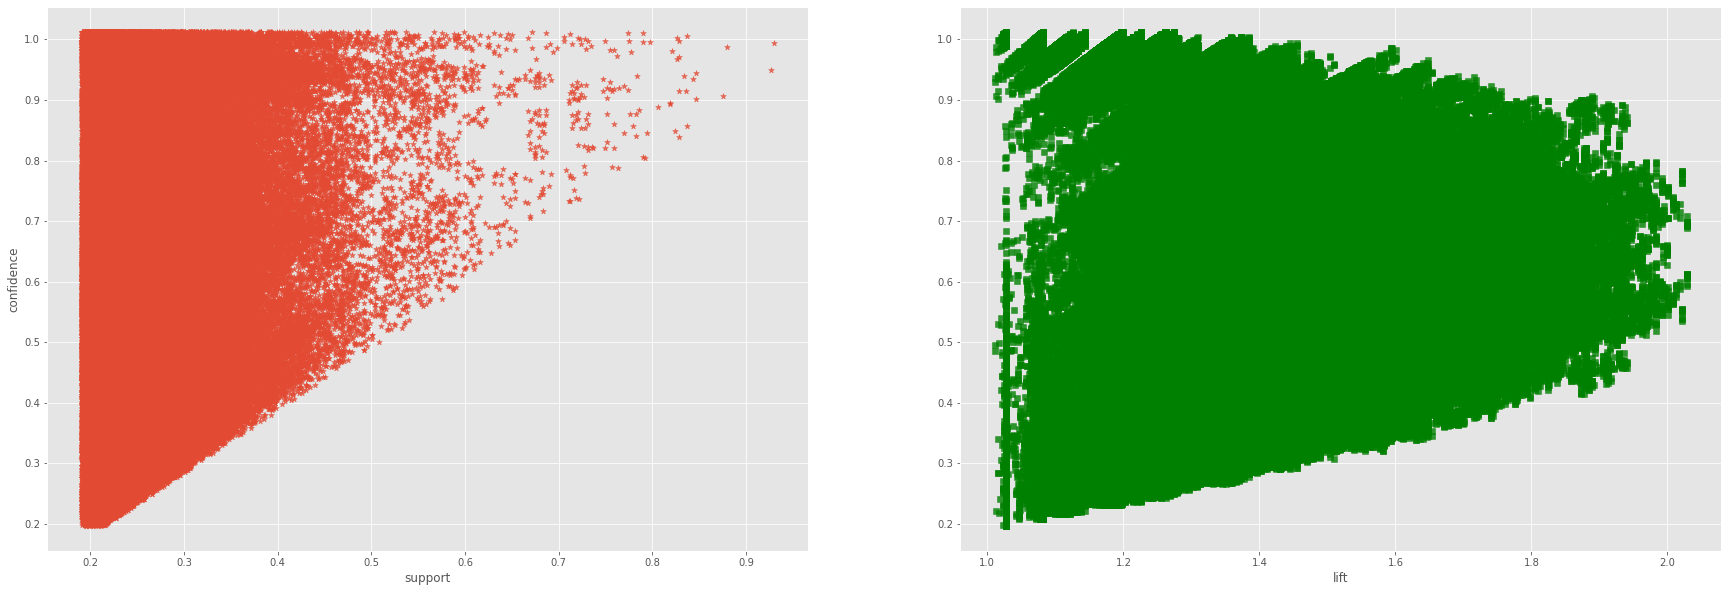

In [57]:
#plot association rules
plot_assoc_rules(rules[['support']].values,rules[['confidence']].values,rules[['lift']].values)

In [58]:
#fetch the most reliable association rules
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.max_colwidth', None):
    display(rules[ (rules['lift'] >= 2) &
        (rules['confidence'] >= 0.77)].sort_values(['lift'],ascending=False) )

antecedents  \
506045                                          (DEAD ANIMAL COLLECTION, 311 DOCUMENT, MISSED SERVICE, TRANSPORTATION)   
626234                    (NON_RECYCLABLE ITEMS, DEAD ANIMAL COLLECTION, MISSED SERVICE, TRANSPORTATION, 311 DOCUMENT)   
626416                                          (DEAD ANIMAL COLLECTION, 311 DOCUMENT, MISSED SERVICE, TRANSPORTATION)   
626779                        (RECYCLABLE ITEMS, DEAD ANIMAL COLLECTION, MISSED SERVICE, TRANSPORTATION, 311 DOCUMENT)   
626926                                          (DEAD ANIMAL COLLECTION, 311 DOCUMENT, MISSED SERVICE, TRANSPORTATION)   
662015  (NON_RECYCLABLE ITEMS, RECYCLABLE ITEMS, 311 DOCUMENT, DEAD ANIMAL COLLECTION, MISSED SERVICE, TRANSPORTATION)   
662246                    (NON_RECYCLABLE ITEMS, DEAD ANIMAL COLLECTION, MISSED SERVICE, TRANSPORTATION, 311 DOCUMENT)   
662351                        (RECYCLABLE ITEMS, DEAD ANIMAL COLLECTION, MISSED SERVICE, TRANSPORTATION, 311 DOCUMENT)   
662582                                          (DEAD ANIMAL COLLECTION, 311 DOCUMENT, MISSED SERVICE, TRANSPORTATION)   

                                                                                          consequents  \
506045                                          (RECYCLING, GARBAGE, CART, HNS HEALTH AND SANITATION)   
626234                                          (RECYCLING, GARBAGE, CART, HNS HEALTH AND SANITATION)   
626416                    (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND SANITATION, RECYCLING, CART)   
626779                                          (RECYCLING, GARBAGE, CART, HNS HEALTH AND SANITATION)   
626926                        (GARBAGE, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION, RECYCLING, CART)   
662015                                          (RECYCLING, GARBAGE, CART, HNS HEALTH AND SANITATION)   
662246                        (GARBAGE, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION, RECYCLING, CART)   
662351                    (NON_RECYCLABLE ITEMS, GARBAGE, HNS HEALTH AND SANITATION, RECYCLING, CART)   
662582  (NON_RECYCLABLE ITEMS, GARBAGE, RECYCLABLE ITEMS, HNS HEALTH AND SANITATION, RECYCLING, CART)   

        antecedent support  consequent support   support  confidence     lift  \
506045            0.269685            0.380906  0.207677    0.770073  2.02169   
626234            0.269685            0.380906  0.207677    0.770073  2.02169   
626416            0.269685            0.380906  0.207677    0.770073  2.02169   
626779            0.269685            0.380906  0.207677    0.770073  2.02169   
626926            0.269685            0.380906  0.207677    0.770073  2.02169   
662015            0.269685            0.380906  0.207677    0.770073  2.02169   
662246            0.269685            0.380906  0.207677    0.770073  2.02169   
662351            0.269685            0.380906  0.207677    0.770073  2.02169   
662582            0.269685            0.380906  0.207677    0.770073  2.02169   

        leverage  conviction  
506045  0.104953     2.69257  
626234  0.104953     2.69257  
626416  0.104953     2.69257  
626779  0.104953     2.69257  
626926  0.104953     2.69257  
662015  0.104953     2.69257  
662246  0.104953     2.69257  
662351  0.104953     2.69257  
662582  0.104953     2.69257

### Inference:
We see some distinct association rules generated by mid and high crime index areas and the ones generated on the entire dataset. 

The highest lift is 2 and we also have some perfect confidence scores of 1.

To select the most frequent association rules, we choose a high lift (>2) and a high confidence too (>0.77 which is close to the 75% mark)

### Conclusion for running Association Rules on the mid & high crime index areas dataset:
We see DEAD ANIMAL COLLECTION, 311 DOCUMENT, TRANSPORTATION and MISSED SERVICE to be a common antecedent such that if any of them are raised, chances of RECYCLABLE ITEMS, NON_RECYCLABLE ITEMS, GARBAGE, CART, RECYCLING, HNS HEALTH AND SANITATION are likely to also be raised in a particular neighborhood profile area during a monthly timeframe. 

In contrast to low income datasets, we do not see VIOLATIONS requests in combinations of association rules, which makes us question if Crime and Violation requests are related to the crime index or low income areas.

## Association Rules for different Neighborhood Profile areas grouped by Request Categories

In [59]:
#updating the merge index to be a combination of month, year and request category type 
requests['MERGE_INDEX']=requests['RECEIVED_MONTH'].astype('str')+'_'+requests['RECEIVED_YEAR'].astype('str')+'_'+requests['REQUEST_CAT'].astype('str')

In [60]:
#create a matrix of merge index and category with the values as sum of requests(number of requests 
# in a particular neighborhood profile area raised per month of a year for a particular neighborhood profile area) 
# we exclude NPA = -1 as these requests do not have any neighborhood profile area associated to them
npa_request_basket = (requests[requests['NEIGHBORHOOD_PROFILE_AREA']!="-1"] 
          .groupby(['MERGE_INDEX','NEIGHBORHOOD_PROFILE_AREA'])['REQ_COUNT']
          .sum().unstack().reset_index().fillna(0)
          .set_index('MERGE_INDEX'))
npa_request_basket.head(20)

NEIGHBORHOOD_PROFILE_AREA            10   100  101   102  103  105  106  107  \
MERGE_INDEX                                                                    
10_2016_311 DOCUMENT                3.0   2.0  0.0   0.0  1.0  0.0  0.0  1.0   
10_2016_ADMINISTRATIVE ACTIONS      2.0   0.0  0.0   0.0  0.0  1.0  0.0  0.0   
10_2016_ANIMAL FOUND REPORT         0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_BLOCKAGE                    0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_BOARDED UP STRUCTURE        0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_BULKY ITEM                  2.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_CART                       18.0   4.0  1.0   2.0  2.0  0.0  0.0  0.0   
10_2016_CLEANLINESS                 0.0   0.0  1.0   0.0  0.0  0.0  0.0  0.0   
10_2016_COMPLAINT                   0.0   1.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_CONTENT IMPROVEMENT PROG    0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_CUSTOMER FEEDBACK           0.0   0.0  0.0   0.0  0.0  1.0  0.0  0.0   
10_2016_CWP                         0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_DEAD ANIMAL COLLECTION      4.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_DISABILITY ACT              0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_DISABLED SERVICE            0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_ESCALATION REQUEST          0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_FIELD OBSERVED PROBLEM      0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0   
10_2016_GARBAGE                     3.0   1.0  0.0   1.0  0.0  0.0  0.0  0.0   
10_2016_HNS HEALTH AND SANITATION  12.0  12.0  1.0  11.0  6.0  0.0  5.0  0.0   
10_2016_HNS HOUSING                 5.0   0.0  1.0   1.0  0.0  0.0  0.0  0.0   

NEIGHBORHOOD_PROFILE_AREA          108  109  ...   90   91   92   93    94  \
MERGE_INDEX                                  ...                             
10_2016_311 DOCUMENT               0.0  0.0  ...  1.0  0.0  0.0  0.0   0.0   
10_2016_ADMINISTRATIVE ACTIONS     0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_ANIMAL FOUND REPORT        0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_BLOCKAGE                   0.0  0.0  ...  0.0  0.0  0.0  0.0   1.0   
10_2016_BOARDED UP STRUCTURE       0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_BULKY ITEM                 0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_CART                       1.0  1.0  ...  0.0  1.0  0.0  0.0   5.0   
10_2016_CLEANLINESS                0.0  1.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_COMPLAINT                  0.0  0.0  ...  0.0  0.0  1.0  0.0   0.0   
10_2016_CONTENT IMPROVEMENT PROG   0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_CUSTOMER FEEDBACK          1.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_CWP                        0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_DEAD ANIMAL COLLECTION     0.0  0.0  ...  0.0  0.0  0.0  1.0   0.0   
10_2016_DISABILITY ACT             0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_DISABLED SERVICE           0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_ESCALATION REQUEST         0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_FIELD OBSERVED PROBLEM     0.0  0.0  ...  0.0  0.0  0.0  0.0   0.0   
10_2016_GARBAGE                    2.0  1.0  ...  1.0  5.0  0.0  0.0   0.0   
10_2016_HNS HEALTH AND SANITATION  2.0  0.0  ...  7.0  3.0  0.0  2.0  11.0   
10_2016_HNS HOUSING                0.0  0.0  ...  0.0  1.0  0.0  0.0   0.0   

NEIGHBORHOOD_PROFILE_AREA            95   96   97    98    99  
MERGE_INDEX                                                    
10_2016_311 DOCUMENT                0.0  1.0  2.0   2.0   1.0  
10_2016_ADMINISTRATIVE ACTIONS      0.0  0.0  0.0   0.0   0.0  
10_2016_ANIMAL FOUND REPORT         0.0  0.0  0.0   0.0   0.0  
10_2016_BLOCKAGE                    1.0  0.0  0.0   0.0   0.0  
10_2016_BOARDED UP STRUCTURE        0.0  0.0  0.0   0.0   0.0  
10_2016_BULKY ITEM                  0.0  1.0  0.0   0.0   0.0  
10_2016_CA

In [61]:
npa_request_basket.shape

(2155, 462)

In [62]:
#update the values in the high_crime_basket
npa_request_basket_sets = npa_request_basket.applymap(encode_units)
npa_request_basket_sets.head(20)

NEIGHBORHOOD_PROFILE_AREA          10  100  101  102  103  105  106  107  108  \
MERGE_INDEX                                                                     
10_2016_311 DOCUMENT                1    1    0    0    1    0    0    1    0   
10_2016_ADMINISTRATIVE ACTIONS      1    0    0    0    0    1    0    0    0   
10_2016_ANIMAL FOUND REPORT         0    0    0    0    0    0    0    0    0   
10_2016_BLOCKAGE                    0    0    0    0    0    0    0    0    0   
10_2016_BOARDED UP STRUCTURE        0    0    0    0    0    0    0    0    0   
10_2016_BULKY ITEM                  1    0    0    0    0    0    0    0    0   
10_2016_CART                        1    1    1    1    1    0    0    0    1   
10_2016_CLEANLINESS                 0    0    1    0    0    0    0    0    0   
10_2016_COMPLAINT                   0    1    0    0    0    0    0    0    0   
10_2016_CONTENT IMPROVEMENT PROG    0    0    0    0    0    0    0    0    0   
10_2016_CUSTOMER FEEDBACK           0    0    0    0    0    1    0    0    1   
10_2016_CWP                         0    0    0    0    0    0    0    0    0   
10_2016_DEAD ANIMAL COLLECTION      1    0    0    0    0    0    0    0    0   
10_2016_DISABILITY ACT              0    0    0    0    0    0    0    0    0   
10_2016_DISABLED SERVICE            0    0    0    0    0    0    0    0    0   
10_2016_ESCALATION REQUEST          0    0    0    0    0    0    0    0    0   
10_2016_FIELD OBSERVED PROBLEM      0    0    0    0    0    0    0    0    0   
10_2016_GARBAGE                     1    1    0    1    0    0    0    0    1   
10_2016_HNS HEALTH AND SANITATION   1    1    1    1    1    0    1    0    1   
10_2016_HNS HOUSING                 1    0    1    1    0    0    0    0    0   

NEIGHBORHOOD_PROFILE_AREA          109  ...  90  91  92  93  94  95  96  97  \
MERGE_INDEX                             ...                                   
10_2016_311 DOCUMENT                 0  ...   1   0   0   0   0   0   1   1   
10_2016_ADMINISTRATIVE ACTIONS       0  ...   0   0   0   0   0   0   0   0   
10_2016_ANIMAL FOUND REPORT          0  ...   0   0   0   0   0   0   0   0   
10_2016_BLOCKAGE                     0  ...   0   0   0   0   1   1   0   0   
10_2016_BOARDED UP STRUCTURE         0  ...   0   0   0   0   0   0   0   0   
10_2016_BULKY ITEM                   0  ...   0   0   0   0   0   0   1   0   
10_2016_CART                         1  ...   0   1   0   0   1   1   1   1   
10_2016_CLEANLINESS                  1  ...   0   0   0   0   0   0   0   0   
10_2016_COMPLAINT                    0  ...   0   0   1   0   0   0   0   1   
10_2016_CONTENT IMPROVEMENT PROG     0  ...   0   0   0   0   0   0   0   0   
10_2016_CUSTOMER FEEDBACK            0  ...   0   0   0   0   0   0   0   0   
10_2016_CWP                          0  ...   0   0   0   0   0   0   0   0   
10_2016_DEAD ANIMAL COLLECTION       0  ...   0   0   0   1   0   1   0   0   
10_2016_DISABILITY ACT               0  ...   0   0   0   0   0   0   0   0   
10_2016_DISABLED SERVICE             0  ...   0   0   0   0   0   0   0   0   
10_2016_ESCALATION REQUEST           0  ...   0   0   0   0   0   0   0   1   
10_2016_FIELD OBSERVED PROBLEM       0  ...   0   0   0   0   0   0   0   0   
10_2016_GARBAGE                      1  ...   1   1   0   0   0   1   0   1   
10_2016_HNS HEALTH AND SANITATION    0  ...   1   1   0   1   1   1   1   1   
10_2016_HNS HOUSING                  0  ...   0   1   0   0   0   1   0   0   

NEIGHBORHOOD_PROFILE_AREA          98  99  
MERGE_INDEX                                
10_2016_311 DOCUMENT                1   1  
10_2016_ADMINISTRATIVE ACTIONS      0   0  
10_2016_ANIMAL FOUND REPORT         0   0  
10_2016_BLOCKAGE                    0   0  
10_2016_BOARDED UP STRUCTURE        0   0  
10_2016_BULKY ITEM                  0   0  
10_2016_CART                        1   0  
10_2016_CLEANLINESS                 0   0  
10_2016_COMPLAINT                   0 

In [63]:
#creating the frequest request sets. We use a minimum support of 0.5 to create 
# more number of frequent lists than seen above
rules=create_assoc_rules("lift",0.3,1,npa_request_basket_sets)
rules.head(30)

antecedents consequents  antecedent support  consequent support   support  \
0        (100)        (10)            0.397216            0.522042  0.322042   
1         (10)       (100)            0.522042            0.397216  0.322042   
2         (11)        (10)            0.393503            0.522042  0.306729   
3         (10)        (11)            0.522042            0.393503  0.306729   
4        (113)        (10)            0.484455            0.522042  0.362413   
5         (10)       (113)            0.522042            0.484455  0.362413   
6        (117)        (10)            0.433875            0.522042  0.337819   
7         (10)       (117)            0.522042            0.433875  0.337819   
8        (121)        (10)            0.374942            0.522042  0.305336   
9         (10)       (121)            0.522042            0.374942  0.305336   
10       (123)        (10)            0.464501            0.522042  0.361485   
11        (10)       (123)            0.522042            0.464501  0.361485   
12       (124)        (10)            0.419490            0.522042  0.339211   
13        (10)       (124)            0.522042            0.419490  0.339211   
14       (125)        (10)            0.433875            0.522042  0.348492   
15        (10)       (125)            0.522042            0.433875  0.348492   
16       (128)        (10)            0.388399            0.522042  0.313225   
17        (10)       (128)            0.522042            0.388399  0.313225   
18       (139)        (10)            0.371230            0.522042  0.303944   
19        (10)       (139)            0.522042            0.371230  0.303944   
20        (14)        (10)            0.390719            0.522042  0.312297   
21        (10)        (14)            0.522042            0.390719  0.312297   
22       (140)        (10)            0.456148            0.522042  0.360093   
23        (10)       (140)            0.522042            0.456148  0.360093   
24       (147)        (10)            0.380046            0.522042  0.304872   
25        (10)       (147)            0.522042            0.380046  0.304872   
26       (158)        (10)            0.432019            0.522042  0.329930   
27        (10)       (158)            0.522042            0.432019  0.329930   
28        (16)        (10)            0.509977            0.522042  0.389791   
29        (10)        (16)            0.522042            0.509977  0.389791   

    confidence      lift  leverage  conviction  
0     0.810748  1.553032  0.114679    2.525508  
1     0.616889  1.553032  0.114679    1.573393  
2     0.779481  1.493139  0.101303    2.167426  
3     0.587556  1.493139  0.101303    1.470493  
4     0.748084  1.432997  0.109507    1.897294  
5     0.694222  1.432997  0.109507    1.686013  
6     0.778610  1.491470  0.111318    2.158893  
7     0.647111  1.491470  0.111318    1.604259  
8     0.814356  1.559945  0.109601    2.574602  
9     0.584889  1.559945  0.109601    1.505761  
10    0.778222  1.490727  0.118996    2.155118  
11    0.692444  1.490727  0.118996    1.741145  
12    0.808628  1.548972  0.120220    2.497539  
13    0.649778  1.548972  0.120220    1.657549  
14    0.803209  1.538591  0.121991    2.428755  
15    0.667556  1.538591  0.121991    1.702917  
16    0.806452  1.544803  0.110465    2.469451  
17    0.600000  1.544803  0.110465    1.529002  
18    0.818750  1.568361  0.110147    2.637011  
19    0.582222  1.568361  0.110147    1.505035  
20    0.799287  1.531079  0.108325    2.381307  
21    0.598222  1.531079  0.108325    1.516462  
22    0.789420  1.512178  0.121964    2.269724  
23    0.689778  1.512178  0.121964    1.753103  
24    0.802198  1.536654  0.106472    2.416344  
25    0.584000  1.536654  0.106472    1.490273  
26    0.763695  1.462900  0.104399    2.022632  
27    0.632000  1.462900  0.104399    1.543428  
28    0.764331  1.464119  0.123562    2.028093  
29    0.746667  1.464119  0.123562    1.934302

In [64]:
rules.tail(30)

antecedents           consequents  antecedent support  \
37192  (371, 389, 385, 392)                 (393)            0.345708   
37193  (371, 389, 393, 392)                 (385)            0.338283   
37194  (393, 389, 385, 392)                 (371)            0.322506   
37195  (393, 371, 389, 385)                 (392)            0.339211   
37196  (393, 371, 385, 392)                 (389)            0.347100   
37197       (371, 389, 392)            (393, 385)            0.389327   
37198       (389, 385, 392)            (371, 393)            0.368445   
37199       (389, 393, 392)            (371, 385)            0.357773   
37200       (371, 389, 385)            (393, 392)            0.410209   
37201       (371, 389, 393)            (385, 392)            0.381439   
37202       (393, 389, 385)            (371, 392)            0.358237   
37203       (371, 385, 392)            (389, 393)            0.402320   
37204       (371, 393, 392)            (389, 385)            0.397216   
37205       (393, 385, 392)            (371, 389)            0.373086   
37206       (393, 371, 385)            (389, 392)            0.387007   
37207            (389, 392)       (393, 371, 385)            0.425058   
37208            (371, 389)       (393, 385, 392)            0.476566   
37209            (389, 385)       (371, 393, 392)            0.444084   
37210            (389, 393)       (371, 385, 392)            0.412993   
37211            (371, 392)       (393, 389, 385)            0.479814   
37212            (385, 392)       (371, 389, 393)            0.441299   
37213            (393, 392)       (371, 389, 385)            0.437123   
37214            (371, 385)       (389, 393, 392)            0.491415   
37215            (371, 393)       (389, 385, 392)            0.458469   
37216            (393, 385)       (371, 389, 392)            0.419490   
37217                 (389)  (393, 371, 385, 392)            0.552204   
37218                 (392)  (393, 371, 389, 385)            0.562413   
37219                 (371)  (393, 389, 385, 392)            0.632947   
37220                 (385)  (371, 389, 393, 392)            0.565661   
37221                 (393)  (371, 389, 385, 392)            0.528538   

       consequent support   support  confidence      lift  leverage  \
37192            0.528538  0.307657    0.889933  1.683762  0.124937   
37193            0.565661  0.307657    0.909465  1.607791  0.116303   
37194            0.632947  0.307657    0.953957  1.507168  0.103528   
37195            0.562413  0.307657    0.906977  1.612653  0.116880   
37196            0.552204  0.307657    0.886364  1.605138  0.115987   
37197            0.419490  0.307657    0.790226  1.883781  0.144338   
37198            0.458469  0.307657    0.835013  1.821308  0.138736   
37199            0.491415  0.307657    0.859922  1.749889  0.131842   
37200            0.437123  0.307657    0.750000  1.715764  0.128345   
37201            0.441299  0.307657    0.806569  1.827715  0.139328   
37202            0.479814  0.307657    0.858808  1.789876  0.135770   
37203            0.412993  0.307657    0.764706  1.851619  0.141501   
37204            0.444084  0.307657    0.774533  1.744115  0.131260   
37205            0.476566  0.307657    0.824627  1.730351  0.129857   
37206            0.425058  0.307657    0.794964  1.870248  0.143156   
37207            0.387007  0.307657    0.723799  1.870248  0.143156   
37208            0.373086  0.307657    0.645570  1.730351  0.129857   
37209            0.397216  0.307657    0.692790  1.744115  0.131260   
37210            0.402320  0.307657    0.744944  1.851619  0.141501   
37211            0.358237  0.307657    0.641199  1.789876  0.135770   
37212            0.381439  0.307657    0.697161  1.827715  0.139328   
37213            0.410209  0.307657    0.703822  1.715764  0.128345   
37214            0.357773  0.307657    0.626062  1.749889  0.131842   
37215            0.368445  0.307657    0.671053 

In [65]:
rules.describe()

antecedent support  consequent support       support    confidence  \
count        37222.000000        37222.000000  37222.000000  37222.000000   
mean             0.447234            0.447234      0.315899      0.728123   
std              0.082496            0.082496      0.017425      0.124619   
min              0.310441            0.310441      0.300232      0.474340   
25%              0.379118            0.379118      0.303944      0.623923   
50%              0.434803            0.434803      0.310441      0.732143   
75%              0.509977            0.509977      0.321578      0.831976   
max              0.632947            0.632947      0.491415      0.970803   

               lift      leverage    conviction  
count  37222.000000  37222.000000  37222.000000  
mean       1.633213      0.121445      2.538675  
std        0.100596      0.010446      1.327171  
min        1.342283      0.087292      1.262362  
25%        1.564568      0.114608      1.643163  
50%        1.627717      0.121657      2.108755  
75%        1.699225      0.128570      2.941411  
max        1.960364      0.158161     12.571578

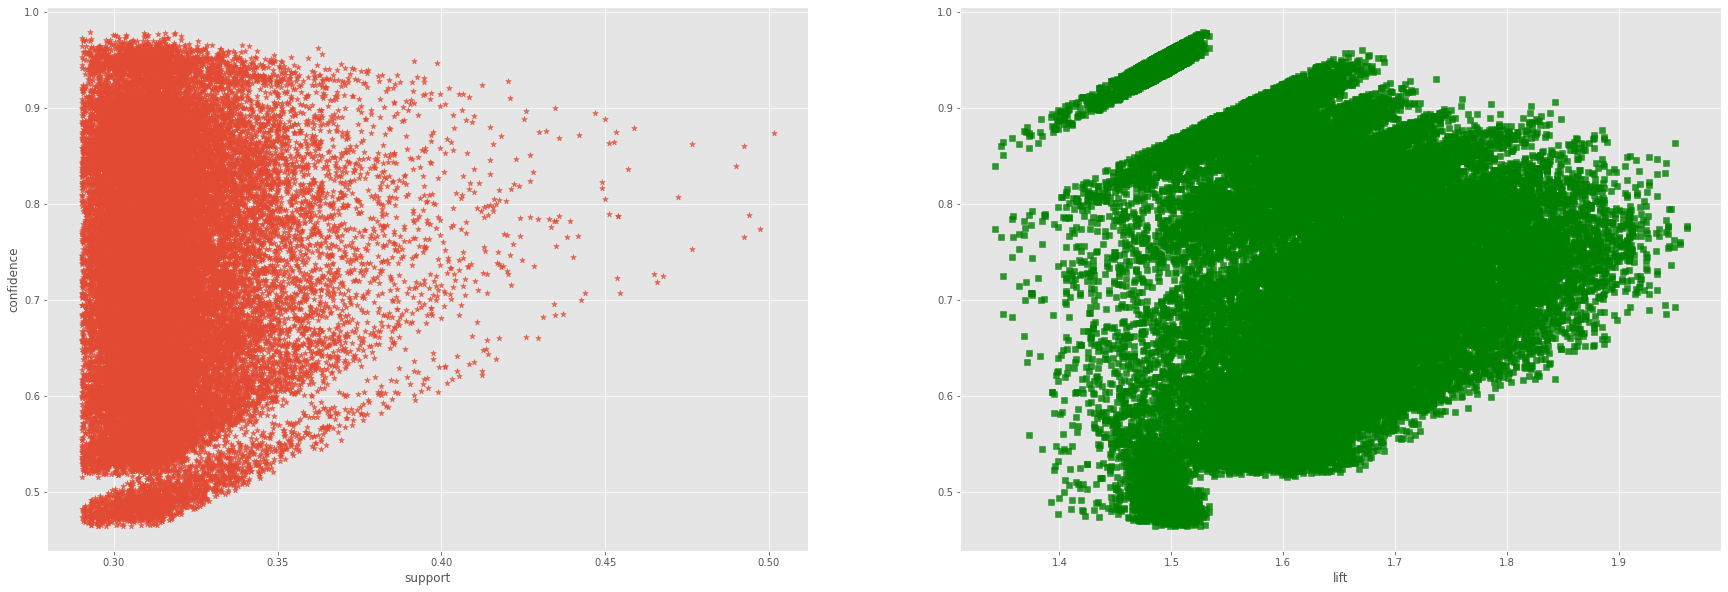

In [66]:
#plot association rules
plot_assoc_rules(rules[['support']].values,rules[['confidence']].values,rules[['lift']].values)

### Inference:
We see the neighborhood profile areas 389, 393, 371, 385 and 392 occur in combinations in a lot of association rulessome.

We also observe the highest lift is 1.9 and highest confidence scores of 0.97.

To select the most frequent association rules, we choose a high lift (>1.9) and a high confidence too (>0.8 which is close to the 75% mark)

In [67]:
#fetch the most reliable association rules
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.max_colwidth', None):
    display(rules[ (rules['lift'] >= 1.9) &
        (rules['confidence'] >= 0.8)].sort_values(['lift'],ascending=False) )

antecedents    consequents  antecedent support  consequent support  \
36363    (3, 371, 367)     (378, 392)            0.356381            0.436659   
31811         (3, 377)     (378, 392)            0.356845            0.436659   
36269  (371, 378, 348)       (3, 393)            0.361949            0.427378   
36963    (393, 3, 385)     (378, 392)            0.361021            0.436659   
37047  (371, 372, 392)     (393, 385)            0.371230            0.419490   
36936    (3, 378, 385)     (389, 392)            0.369838            0.425058   
31993         (3, 388)     (378, 392)            0.362877            0.436659   
36928    (3, 389, 392)     (378, 385)            0.374014            0.421810   
36959  (378, 385, 392)       (3, 393)            0.370302            0.427378   
36195       (260, 378)  (3, 371, 392)            0.381439            0.415777   
36087  (371, 389, 374)      (385, 16)            0.380046            0.416241   
37017  (363, 371, 389)     (374, 385)            0.373550            0.418097   
33518       (387, 363)     (374, 385)            0.375406            0.418097   
36934  (378, 385, 392)       (3, 389)            0.370302            0.427842   
36390    (371, 3, 372)     (378, 392)            0.367981            0.436659   
36988  (371, 348, 392)     (393, 385)            0.373550            0.419490   
36183    (3, 371, 260)     (378, 392)            0.365197            0.436659   
36268    (3, 371, 348)     (378, 393)            0.372622            0.420882   
36929  (389, 378, 392)       (3, 385)            0.362877            0.438515   
37051  (371, 372, 393)     (385, 392)            0.357773            0.441299   
36749  (371, 378, 392)       (3, 393)            0.396752            0.427378   
36327  (371, 348, 392)       (3, 393)            0.373550            0.427378   
35912   (371, 378, 16)       (3, 393)            0.368445            0.427378   
36243    (3, 371, 348)     (378, 392)            0.372622            0.436659   

        support  confidence      lift  leverage  conviction  
36363  0.303480    0.851562  1.950178  0.147864    3.795140  
31811  0.302552    0.847854  1.941686  0.146733    3.702643  
36269  0.300232    0.829487  1.940874  0.145543    3.358233  
36963  0.304872    0.844473  1.933942  0.147229    3.622143  
37047  0.301160    0.811250  1.933898  0.145433    3.075552  
36936  0.303944    0.821832  1.933458  0.146742    3.226963  
31993  0.305336    0.841432  1.926978  0.146883    3.552683  
36928  0.303944    0.812655  1.926592  0.146182    3.086234  
36959  0.304872    0.823308  1.926416  0.146614    3.240796  
36195  0.305336    0.800487  1.925278  0.146743    2.928238  
36087  0.304408    0.800977  1.924309  0.146217    2.933119  
37017  0.300232    0.803727  1.922343  0.144052    2.964757  
33518  0.301160    0.802225  1.918751  0.144204    2.942245  
36934  0.303944    0.820802  1.918469  0.145514    3.192880  
36390  0.308121    0.837327  1.917576  0.147438    3.463019  
36988  0.300232    0.803727  1.915964  0.143532    2.957664  
36183  0.305336    0.836086  1.914736  0.145870    3.436817  
36268  0.300232    0.805729  1.914383  0.143402    2.980974  
36929  0.303944    0.837596  1.910073  0.144817    3.457332  
37051  0.301160    0.841764  1.907467  0.143275    3.530805  
36749  0.323434    0.815205  1.907455  0.153871    3.098681  
36327  0.304408    0.814907  1.906758  0.144761    3.093695  
35912  0.300232    0.814861  1.906652  0.142766    3.092937  
36243  0.309977    0.831880  1.905103  0.147268    3.350836

### Inference:
The above association rules show that certain request types tend to occur together during the same month in the neighborhood profile areas 3, 371, 378, 392, 393, 385. By plotting these on the map with the category types, we can check to see how close these areas are.

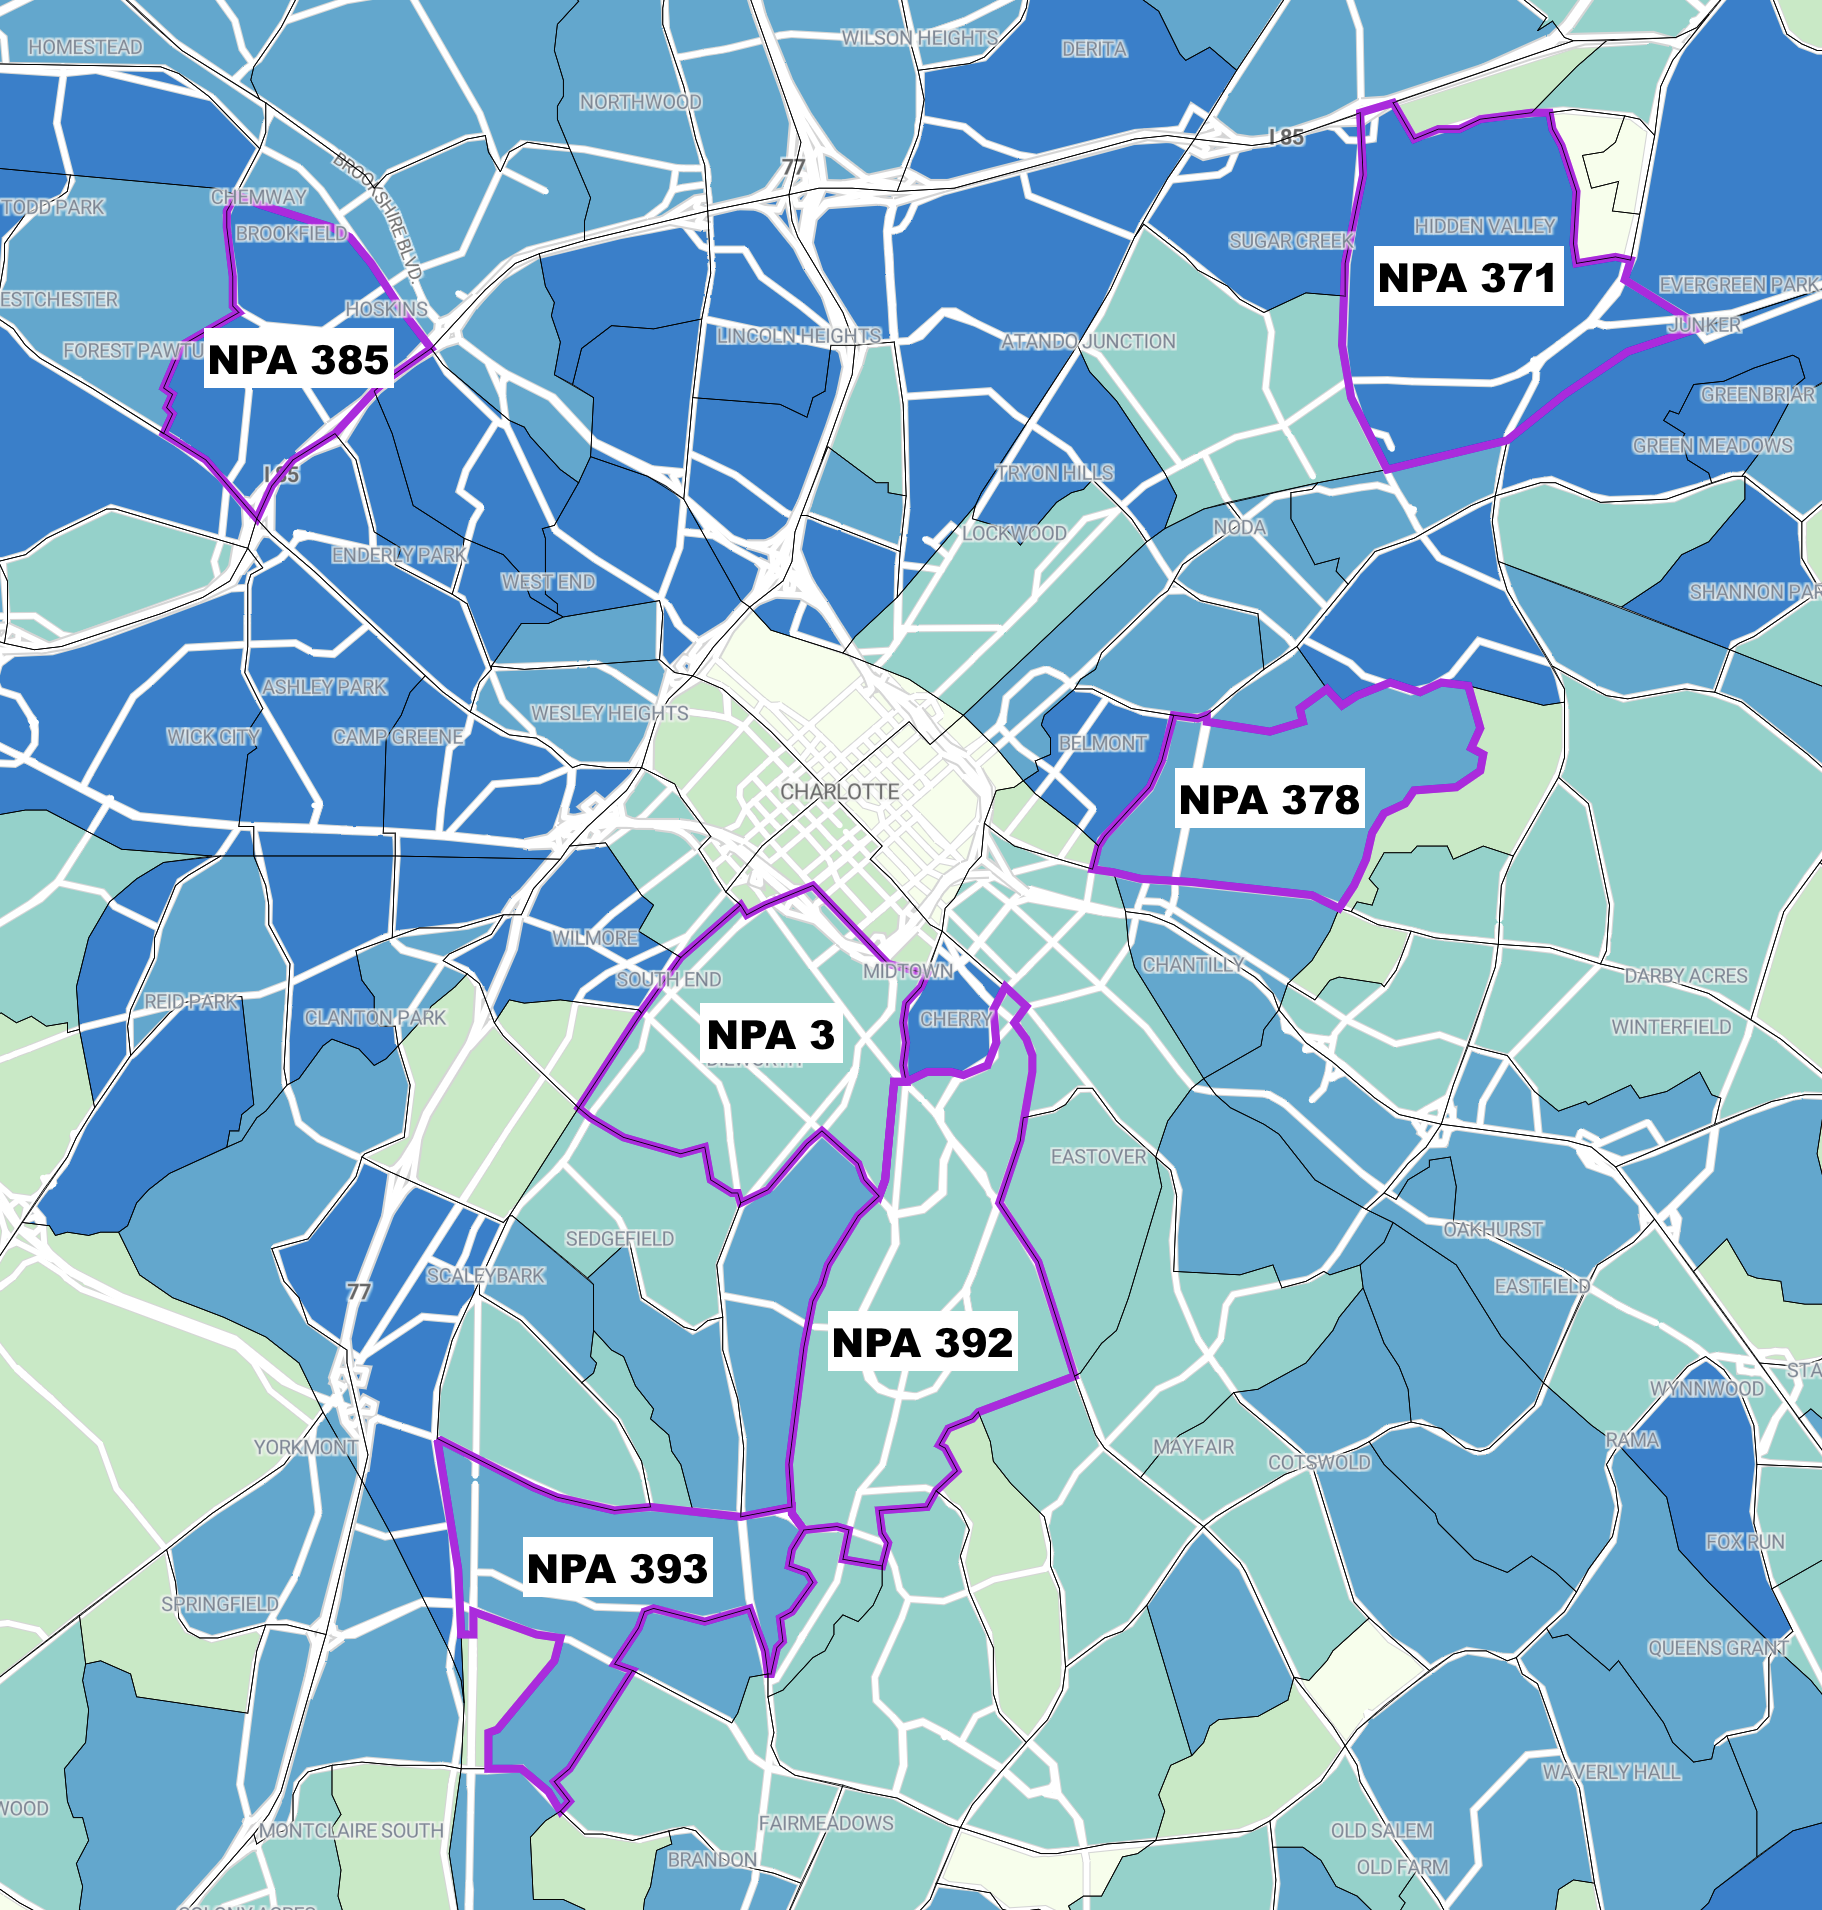

### Conclusion for Association Rules 
We see that there are associations between what kind of requests are raised in different income groups, crime indexes and Neighborhood profile areas. Though NON_RECYCLABLE ITEMS and RECYCLABLE ITEMS are the largest types of requests being raised, we do see other requests like CART, TRANSPORTATION, HNS HEALTH AND SANITATION, MISSED SERVICE, GARBAGE, RECYCLING, VIOLATIONS, DEAD ANIMAL COLLECTION are also seen in some scenarios. Understanding the causality of each of these associations depends on the domain knowledge which we hope to get sometime in the future.